## Instructions For Running The Notebook 

The dataset used with in this project is openly available at: https://www.kaggle.com/datasets/spscientist/students-performance-in-exams
The name of the file to download is StudentsPerformance.csv and can be found by clicking the download button on the top right corner. The file should be downloaded in the same folder as this notebook and should not need to be renamed.

# Student Performance Data Analysis 

## Background Information

The motivation for this analysis comes from the need to better understand student behavior and find factors that attribute to the grades of students. My personal motivation comes from growing up around intercity schools that struggle to produce students with good enough grades to further their education past high school. Additionally, across the industry, it is a common behavior of academia, especially in K-12 schooling, to continue and try and improve on teaching practices. In doing so, a big part of research is analyzing the scores of different groups of students and potientally finding current shortcomings in the education system. In this dataset from Kaggle, 1000 different students' gender, ethnicity, parental level of education, type of lunch, and preperation habits are included as well as their math, writing, and reading exam scores. Note: the specific ethnicity for each student is not listed and instead is denoted by a group (i.e Group A, Group B, etc.). With this we can only specify whether ethnicity factors into academic success, not which ethnicity has a greater rate of success. 

## Scientific Question

Does the gender, ethnicity, parental level of education, lunch type, and preperation habits of a student influence their success on exams?  

## Methodology

In order to determine whether a certain attribute of a student truly impacts their exam scores we will perform a few statistical tests with each attribute's subgroups to determine whether there is statistical difference in the subgroups. 

First using correlation matrices and seaborn pairplots, I will explore the correlation between the success of student in one subject to the success of the same student in another subject. Then, if there is correlation, using the curve fit function, I will use the linear model to approximate the line of best fit for each of the subgroups of the attribute then use the mean absolute error to find the goodness of this model. 

Once I have looked at the lines of best fit of the subgroups and got a feel for the subgroups' surface differences, I will then run the 2-sample z-test and the 2-sample independent t-test to determine if the subgroups are indeed statistically different.
The way that these statistical hypothesis work is by taking in the sample mean, standard deviation, and the number of entries within the sample for each of the 2 samples I am comparing while first assuming the population mean of the samples is the same. It then uses this information to calculate a z-score and a corresponding p-value. The p-value measured the probability that the two samples would occur within the same distribution of samples. A significance level, will be using .05, is established and if the p-value is below the significance level, then the samples are assumed to be from 2 distinct populations meaning there is a distinct difference in the scores between the two groups.  

For each attribute I test, I will be splitting the original dataset into a dataset for each subgroup and for attributes with a larger number of subgroups, I will be using meshgrids to plot a matrix of the permutations of p values. Then, I will calculate the 90% confidence interval of the population mean difference between the two groups as a check to see if 0 is included within the interval. This is how I will check the effectiveness of the t and z tests. This analysis is more statistics driven than a lot of the analysis tools we have done in class and although all of the fits for the data are linear, this statistical analysis is the main mechanism is answering the scientific question. 

In [2]:
#importing modules
import pandas as pd 

import matplotlib.pyplot as plt

import matplotlib.ticker as ticker

import seaborn as sns 

from scipy.optimize import curve_fit 

from scipy.stats import norm as norm

from scipy.stats import ttest_ind as ttest

import numpy as np 

In [3]:
#defining useful functions 

#defining the fitting function 
def Linear(x,m,b):
    
    #linear function definition
    return m * x + b

#defining a function to calculate the mean absolute error 
def calculate_mae(y_true, y_pred):
    
    #caluculating the mean absolute error
    mae = np.mean(np.abs(y_true - y_pred))
    
    return mae

#defining the function to perform the 2-sample Z-test
def twoSampZ(X1, X2, mudiff, sd1, sd2, n1, n2):
    
    #taking the two separate stds and calculating a pooled one 
    pooledSE = np.sqrt(sd1**2/n1 + sd2**2/n2)
    
    #calculating the z-score
    z = ((X1 - X2) - mudiff)/pooledSE
    
    #calculating the corresponding p-value
    pval = 2*(norm.sf(abs(z)))
    
    #return values
    return z, pval

In [4]:
#loading in the student performance data 
student_data = pd.read_csv('StudentsPerformance.csv')

In [5]:
#looking at the info of the dataset
student_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [6]:
#looking at the summary stats of the 3 types of exam scores
student_data.describe()

math score  reading score  writing score
count  1000.00000    1000.000000    1000.000000
mean     66.08900      69.169000      68.054000
std      15.16308      14.600192      15.195657
min       0.00000      17.000000      10.000000
25%      57.00000      59.000000      57.750000
50%      66.00000      70.000000      69.000000
75%      77.00000      79.000000      79.000000
max     100.00000     100.000000     100.000000

<Axes: >

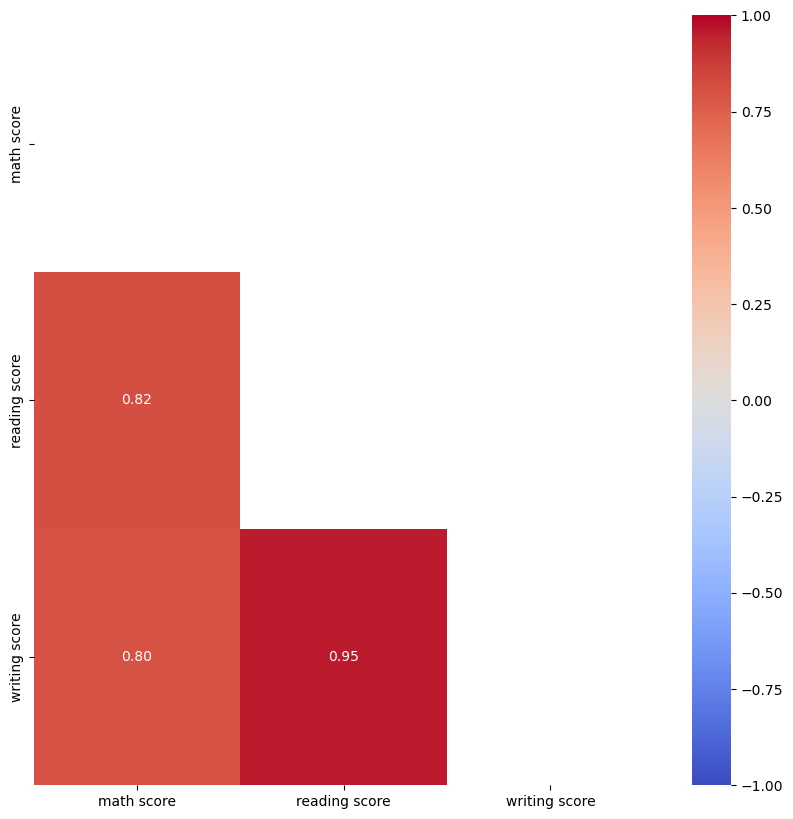

In [7]:
#finding the correlation matrix of the student exam scores
corr_matrix = student_data.corr(numeric_only=True)

#creating a mask to only show the lower triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

#calling the figure constructor and setting the figure size
plt.figure(figsize=(10, 10))

#plotting the heat map of the correlation constants
sns.heatmap(corr_matrix, annot=True, vmin = -1, vmax = 1, fmt=".2f", cmap='coolwarm', mask=mask)

The correlation matrix shows that there is a strong positive correlation between all subjects, but the strongest correlation is between reading and writing scores. 

/Users/trentonsmiley/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x1000 with 0 Axes>

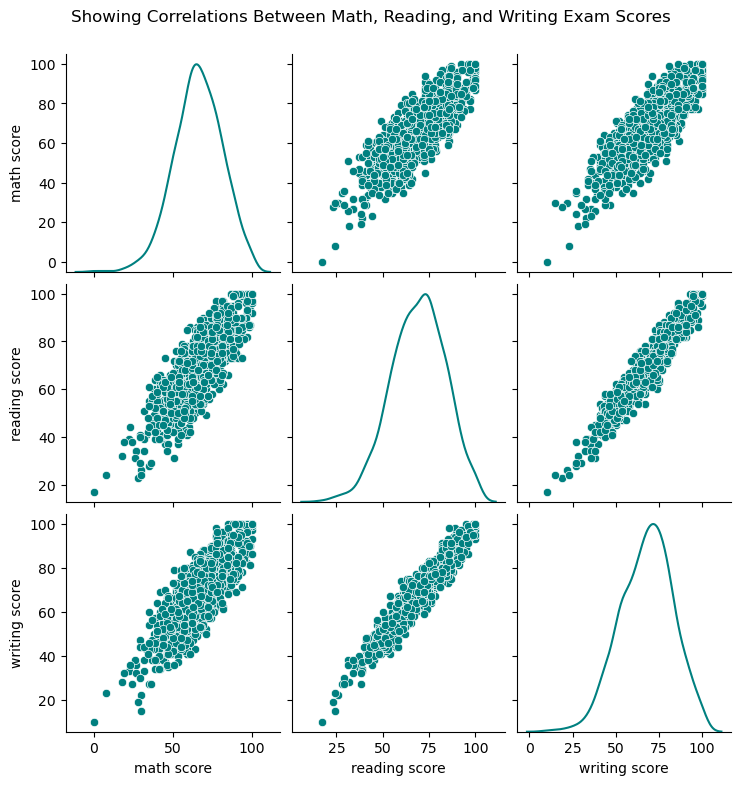

In [8]:
#dropping categorical columns to make all numeric dataframe
numerical_df = student_data.drop([i for i in student_data.columns if i not in ['math score','reading score','writing score']],axis=1)

#calling the figure constructer and setting figure size 
fig = plt.figure(figsize=(10,10))

#making a seaborn pairplot of the columns and calling parameters to customize it 
g = sns.pairplot(numerical_df,diag_kind='kde',plot_kws={'color':'teal'},diag_kws={'fill':False,'color':'teal'})

#setting the title of the figure
g.fig.suptitle('Showing Correlations Between Math, Reading, and Writing Exam Scores',y=1.04)

#saving the plot to files
plt.savefig('Normal Correlation.png')


Here, the pairplot confirms what we saw in the correlation matrix. The reading and writing plot has the least amount of variance from the linear realtionship while math/reading and math/writing relationships have a greater spread and variance from the linear relationship and we can quantify this using linear best-fit lines and calculating their mae (mean absolute error). 

In [9]:
#transposing and unpacking the numerical df into math, reading, and writing scores
math_scores, reading_scores, writing_scores = np.transpose(np.array(numerical_df))

#finding the linear parameters of all combinations of scores
math_writing_parameters, _ = curve_fit(Linear,math_scores,writing_scores)

reading_math_parameters, _ = curve_fit(Linear,reading_scores,math_scores)

writing_reading_parameters, _ = curve_fit(Linear,writing_scores,reading_scores)

#finding the expected scores using parameters and linear model 
expected_writing_scores = Linear(math_scores,math_writing_parameters[0],math_writing_parameters[1])

expected_math_scores = Linear(reading_scores,reading_math_parameters[0],reading_math_parameters[1])

expected_reading_scores = Linear(writing_scores,writing_reading_parameters[0],writing_reading_parameters[1])

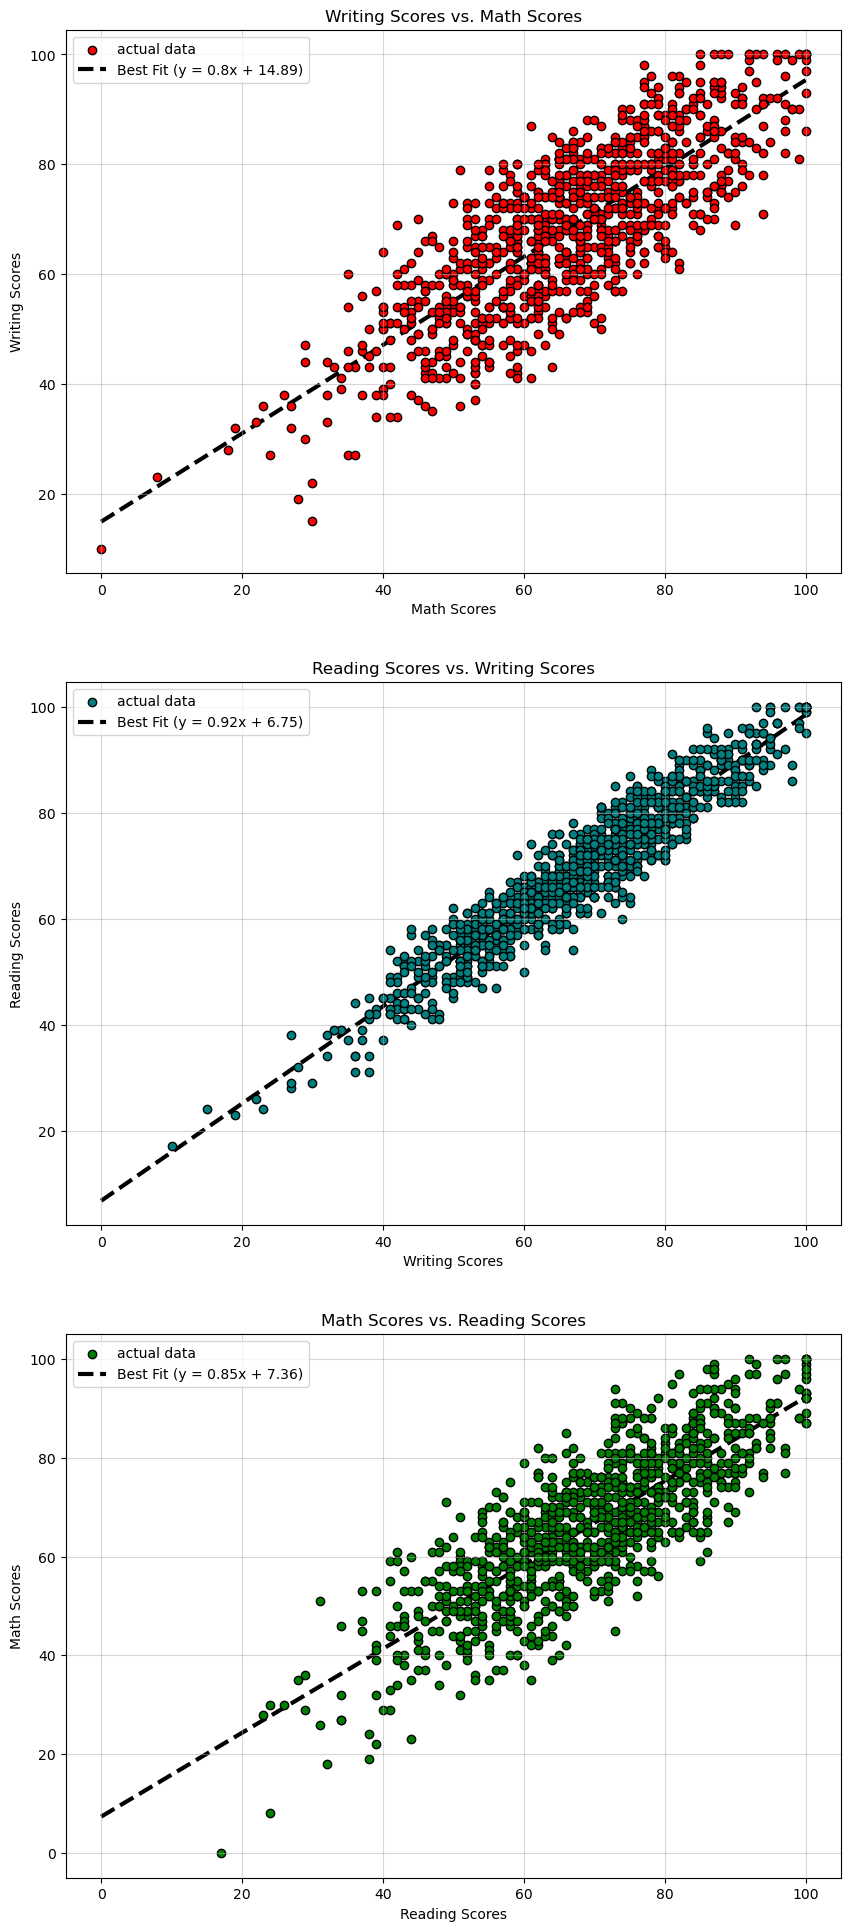

In [10]:
#creating subplot of each scatter plot and line of best fit 
fig,axs = plt.subplots(nrows=3,ncols=1,figsize=(10,24))

#writing v. math scatter plot 
axs[0].scatter(math_scores,writing_scores,color='red',edgecolors='black',label='actual data')

#writing v. math line of best fit 
axs[0].plot([0,max(math_scores)],[math_writing_parameters[1],Linear(max(math_scores),math_writing_parameters[0],math_writing_parameters[1])],
         color='black',linewidth=3,linestyle='dashed',zorder=-20,label=f'Best Fit (y = {round(math_writing_parameters[0],2)}x + {round(math_writing_parameters[1],2)})')

#setting writing v. math axis labels and title 
axs[0].set_xlabel('Math Scores') ; axs[0].set_ylabel('Writing Scores') ; axs[0].set_title('Writing Scores vs. Math Scores')

#reading v. writing scatter plot 
axs[1].scatter(writing_scores,reading_scores,color='teal',edgecolors='black',label='actual data')

#reading v. writing line of best fit 
axs[1].plot([0,max(writing_scores)],[writing_reading_parameters[1],Linear(max(writing_scores),writing_reading_parameters[0],writing_reading_parameters[1])],
         color='black',linewidth=3,linestyle='dashed',zorder=-20,label=f'Best Fit (y = {round(writing_reading_parameters[0],2)}x + {round(writing_reading_parameters[1],2)})')

#setting reading v. writing axis labels and title 
axs[1].set_xlabel('Writing Scores') ; axs[1].set_ylabel('Reading Scores') ; axs[1].set_title('Reading Scores vs. Writing Scores')

#math v. reading scatter plot
axs[2].scatter(reading_scores,math_scores,color='green',edgecolors='black',label='actual data')

#math v. reading line of best fit 
axs[2].plot([0,max(reading_scores)],[reading_math_parameters[1],Linear(max(reading_scores),reading_math_parameters[0],reading_math_parameters[1])],
         color='black',linewidth=3,linestyle='dashed',zorder=-20,label=f'Best Fit (y = {round(reading_math_parameters[0],2)}x + {round(reading_math_parameters[1],2)})')

#setting math v. reading axis labels and title 
axs[2].set_xlabel('Reading Scores') ; axs[2].set_ylabel('Math Scores') ; axs[2].set_title('Math Scores vs. Reading Scores')

#creating a legend and grid for each of the subplots 
for i in range(3):
    
    axs[i].legend()
    
    axs[i].grid(alpha=.5)

#saving the plot to my files
plt.savefig('Normal Best Fits.png')

The above plots visualize the variance in the data for each of the 3 comparisons in subject. Thinking of the line of best fit as a spine, the variance of the data can be see by how loose the scatter points are around that spine. Now to quantify this, we use the mae function to calculate the respective error metrics. 

In [11]:
#calling the function and calculating the mae for all 3 plots
math_writing_mae = calculate_mae(writing_scores,expected_writing_scores)

reading_math_mae = calculate_mae(math_scores,expected_math_scores)

writing_reading_mae = calculate_mae(reading_scores,expected_reading_scores)

#displaying the mae for eacho of the regression lines 
print(f'The mae for the writing v. math regression line is {round(math_writing_mae,2)}.\n\
The mae for the math v. reading regression line is {round(reading_math_mae,2)}.\n\
The mae for the reading v. writing regression line is {round(writing_reading_mae,2)}.')


The mae for the writing v. math regression line is 7.54.
The mae for the math v. reading regression line is 7.06.
The mae for the reading v. writing regression line is 3.47.


From the mae calculations, we see that the writing/math and reading/math linear fits have similar mae's while the mae for the reading/writing relationship is approximately half as big

### Sex Analysis 

The intention of this sex analysis is to answer the question of whether or not students of different sexes have different testing scores. We are purely looking to see if sex affects a student's success not which sex has better testng success. 

First, we must split the data into male and female subsets by creating two masks and applying them to the original data.

In [12]:
#initializing a mask to retrieve only male data
male_mask = student_data['gender'] == 'male' 

#initializng a mask to retrieve only female data
female_mask = student_data['gender'] == 'female'

#creating a male student dataset
male_data = student_data[male_mask]

#creating a female student dataset
female_data = student_data[female_mask]

<Axes: title={'center': 'Female Correlation Matrix'}>

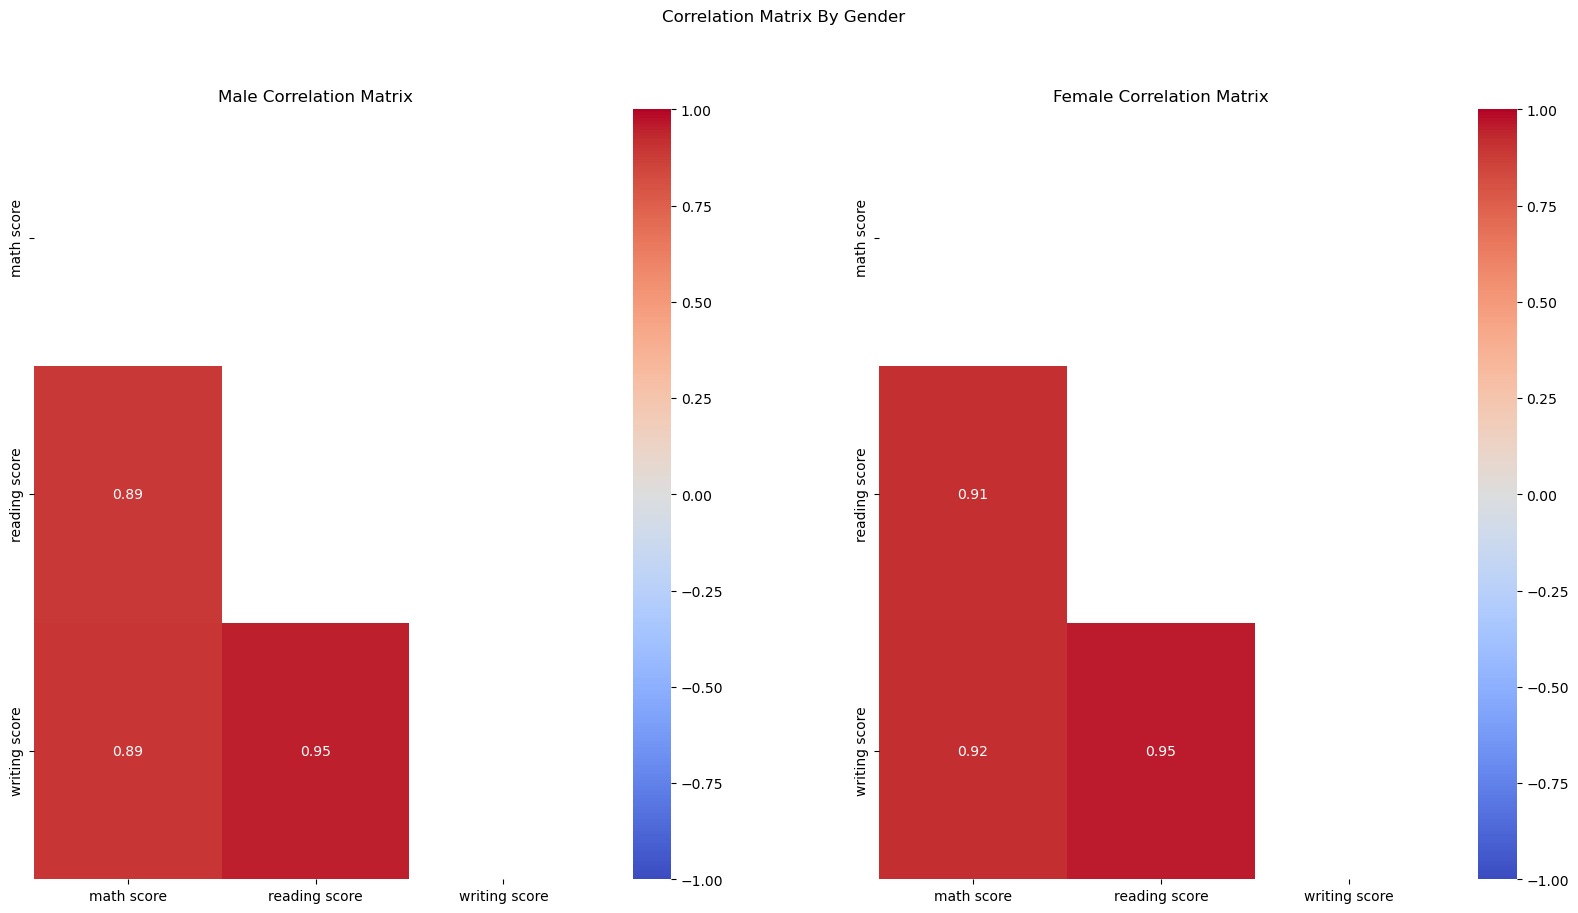

In [13]:
#finding the male student correlation matrix
male_corr_matrix = male_data.corr(numeric_only=True)

#finding the female student correlation matrix
female_corr_matrix = female_data.corr(numeric_only=True)

#creating masks for male and female correlation matrices to only show the lower triangle
male_mask = np.triu(np.ones_like(male_corr_matrix, dtype=bool))

female_mask = np.triu(np.ones_like(female_corr_matrix, dtype=bool))

#initializing figure to plot the matrices
fig, axs = plt.subplots(1,2,figsize=(20, 10))

#setting title of male correlation plot
axs[0].set_title('Male Correlation Matrix')

#setting title of female correlation plot
axs[1].set_title('Female Correlation Matrix')

#setting the super title of the figure 
fig.suptitle('Correlation Matrix By Gender')

#plotting the male correlation matrix as a heat map
sns.heatmap(male_corr_matrix, annot=True, vmin = -1, vmax = 1, fmt=".2f", cmap='coolwarm', mask=male_mask, ax=axs[0])

#plotting the female correlation matrix as a heat map 
sns.heatmap(female_corr_matrix, annot=True, vmin = -1, vmax = 1, fmt=".2f", cmap='coolwarm', mask=female_mask, ax=axs[1])

Here we see the correlation matrices for the respective male and female subgroups. Comparing these to the original correlation matrix, we see a stronger correlation between the math/reading and math/writing relationships than we saw with the whole dataset. The correlation between reading and writing is the same as before for both of the subsets. 

/Users/trentonsmiley/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x1000 with 0 Axes>

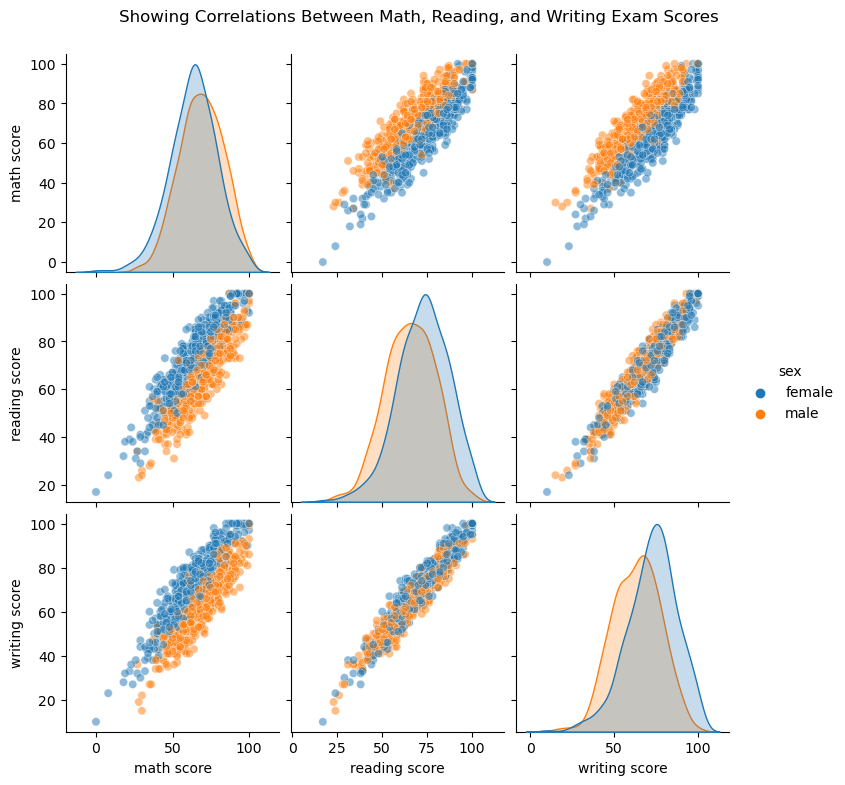

In [14]:
#recreating the numerical dataframe of the original student data
numerical_df = student_data.drop([i for i in student_data.columns if i not in ['math score','reading score','writing score','gender']],axis=1)

#calling the figure constructer and setting figure size 
fig = plt.figure(figsize=(10,10))

#making a seaborn pairplot of the columns and calling parameters to customize it 
#this time we use the hue parameter to separate the data by gender
g = sns.pairplot(numerical_df,hue='gender',diag_kind='kde',plot_kws={'color':'teal','alpha':0.5},diag_kws={'fill':True,'color':'teal'})

#changing the title of the legend
g._legend.set_title('sex')

#setting the title of the figure
g.fig.suptitle('Showing Correlations Between Math, Reading, and Writing Exam Scores',y=1.04)

#saving the plot to files 
plt.savefig('Gender Correlation.png')

In this pairplot, we separate the data by sex and can see how each of the sexes vary. We can see that the correlation increase in the two math relationships can be thought of as having two individual spines instead of one and seeing that each of the subsets of data is more tightly spread around their each individual spine. This is visualized by the separation of color in those plots. While for the reading/writing plot, the colors are intertwined and tightly compact meaning that the two individual spines are most likely very close to the original, hence the constant correlation. 

In [15]:
#initializing variables that store the male test scores separated by subject
male_math_scores, male_reading_scores, male_writing_scores = np.array(male_data['math score']), np.array(male_data['reading score']), np.array(male_data['writing score'])

#initializing variables that store the female test scores separated by subject
female_math_scores, female_reading_scores, female_writing_scores = np.array(female_data['math score']), np.array(female_data['reading score']), np.array(female_data['writing score'])

#calculating the male mean values for each subject 
male_math_mean, male_reading_mean, male_writing_mean = np.mean(male_math_scores), np.mean(male_reading_scores), np.mean(male_writing_scores)

#calculating the female mean values for each subject
female_math_mean, female_reading_mean, female_writing_mean = np.mean(female_math_scores), np.mean(female_reading_scores), np.mean(female_writing_scores)

#calculating the male standard deviations for each subject
male_math_std, male_reading_std, male_writing_std = np.std(male_math_scores), np.std(male_reading_scores), np.std(male_writing_scores)

#calculating female standard deviations for each subject
female_math_std, female_reading_std, female_writing_std = np.std(female_math_scores), np.std(female_reading_scores), np.std(female_writing_scores)

#setting variables equal to the number of students who were male and female 
n_male, n_female = len(male_data), len(female_data)

#displaying the results 
print(f'There are {n_male} entries that are male. There are {n_female} that are female.')

print(f'The mean and standard deviation for male math scores is {round(male_math_mean,2)} and {round(male_math_std,2)}.')

print(f'The mean and standard deviation for male reading scores is {round(male_reading_mean,2)} and {round(male_reading_std,2)}.')

print(f'The mean and standard deviation for male math scores is {round(male_writing_mean,2)} and {round(male_writing_std,2)}.')

print(f'The mean and standard deviation for female math scores is {round(female_math_mean,2)} and {round(female_math_std,2)}.')

print(f'The mean and standard deviation for female reading scores is {round(female_reading_mean,2)} and {round(female_reading_std,2)}.')

print(f'The mean and standard deviation for female writing scores is {round(female_writing_mean,2)} and {round(female_writing_std,2)}.')

There are 482 entries that are male. There are 518 that are female.
The mean and standard deviation for male math scores is 68.73 and 14.34.
The mean and standard deviation for male reading scores is 65.47 and 13.92.
The mean and standard deviation for male math scores is 63.31 and 14.1.
The mean and standard deviation for female math scores is 63.63 and 15.48.
The mean and standard deviation for female reading scores is 72.61 and 14.36.
The mean and standard deviation for female writing scores is 72.47 and 14.83.


Here we calculate the summary stats necessary to perform the statistical tests needed in order to determine if sex does have an impact on a student's exam scores. We calculate the mean score and standard deviation for male and females of each subject and we also store the number of male and female students within the data. One other parameter of the z-test is to specifiy the mean difference in the populations that we want to test its validity. Here, we use 0 as our mean difference as to test whether or not the samples belong to the same population.

In [16]:
#running two sample Z-test for math scores by sex
math_z, math_p = twoSampZ(male_math_mean,female_math_mean,0,male_math_std,female_math_std,n_male,n_female)

#running two sample Z-test for reading scores by sex
reading_z, reading_p = twoSampZ(male_reading_mean,female_reading_mean,0,male_reading_std,female_reading_std,n_male,n_female)

#running two sample Z-test for writing scores by sex
writing_z, writing_p = twoSampZ(male_writing_mean,female_writing_mean,0,male_writing_std,female_writing_std,n_male,n_female)

#displaying the results 
print('With a significance level of .05:\n')

print(f'The z-score and corresponding p-value for math scores between male and female is {round(math_z,2)} and {math_p:.3g}.')

print(f'The z-score and corresponding p-value for reading scores between male and female is {round(reading_z,2)} and {reading_p:.3g}.')

print(f'The z-score and corresponding p-value for writing scores between male and female is {round(writing_z,2)} and {writing_p:.3g}.')

With a significance level of .05:

The z-score and corresponding p-value for math scores between male and female is 5.4 and 6.54e-08.
The z-score and corresponding p-value for reading scores between male and female is -7.98 and 1.51e-15.
The z-score and corresponding p-value for writing scores between male and female is -10.01 and 1.41e-23.


A high z-score implies that the difference in sample calculated is very uncommon when looking at a distribution of samples with a mean difference of 0. The corresponding p-value gives a measure of the probability of a z-score of this value. Therfore, a high z-score and low p-value, one lower than the significance level, implies that the difference in the samples is significant and the samples can be seen as having population means not equal to eachother. 

From the performed z tests we can see that for each of the subjects, the difference in samples between the male and female subsets is significant. 

In [17]:
#running two sample T-test for math scores by sex
math_ttest = ttest(male_math_scores,female_math_scores,equal_var=False)

#unpacking the resulting bunch object into the t-statistic, the p-value, and confidence interval
math_t, math_tp, math_conf_interval = math_ttest.statistic, math_ttest.pvalue, math_ttest.confidence_interval(confidence_level=.9)

#running two sample T-test for reading scores by sex
reading_ttest = ttest(male_reading_scores,female_reading_scores,equal_var=False)

#unpacking the resulting bunch object into the t-statistic, the p-value, and confidence interval
reading_t, reading_tp, reading_conf_interval = reading_ttest.statistic, reading_ttest.pvalue, reading_ttest.confidence_interval(confidence_level=.9)

#running two sample T-test for writing scores by sex
writing_ttest = ttest(male_writing_scores,female_writing_scores,equal_var=False)

#unpacking the resulting bunch object into the t-statistic, the p-value, and confidence interval
writing_t, writing_tp, writing_conf_interval = writing_ttest.statistic, writing_ttest.pvalue, writing_ttest.confidence_interval(confidence_level=.9)

#displaying the results 
print('Male v. Female T-Test\n')

print('Math')

print(f't-statistic, p-value: {round(math_t,2)} & {math_tp:.3g}\n90% confidence interval:({math_conf_interval.low:.2f},{math_conf_interval.high:.2f})\n')

print('Reading')

print(f't-statistic, p-value: {round(reading_t,2)} & {reading_tp:.3g}\n90% confidence interval: ({reading_conf_interval.low:.2f},{reading_conf_interval.high:.2f})\n')

print('Writing')

print(f't-statistic, p-value: {round(writing_t,2)} & {writing_tp:.3g}\n90% confidence interval: ({writing_conf_interval.low:.2f},{writing_conf_interval.high:.2f})\n')



Male v. Female T-Test

Math
t-statistic, p-value: 5.4 & 8.42e-08
90% confidence interval:(3.54,6.65)

Reading
t-statistic, p-value: -7.97 & 4.38e-15
90% confidence interval: (-8.61,-5.66)

Writing
t-statistic, p-value: -10.0 & 1.71e-22
90% confidence interval: (-10.66,-7.65)



Rather than performing the t-test with summary stats like the z-test, we will perform the t-test with the list of scores for the specific sex of each subject as a way of covering our bases. The t-test is similar to the z-test as it returns a test statistic t that if high acts much like a high z-score. The t-test also returns a p-value that, if it lines up with the size of the p-value for the z-test, will help to reinforce the results of our analysis. The t-test function in use also returns the confidence interval of the difference in population means between the two samples which, if it doesn't include 0, is another piece of evidence that the samples are from different populations. 

From the tests, we see that the p-values of each of the subjects are nearly 0 and the confidence intervals all do not include 0. 

In [18]:
#finding the linear parameters of the male writing v. math regression line
male_math_writing_parameters, _ = curve_fit(Linear,male_math_scores,male_writing_scores)

#finding the linear parameters of the male math v. reading regression line  
male_reading_math_parameters, _ = curve_fit(Linear,male_reading_scores,male_math_scores)

#finding the linear parameters of the male reading v. writing regression line 
male_writing_reading_parameters, _ = curve_fit(Linear,male_writing_scores,male_reading_scores)

#using the male writing v. math parameters with the linear model to find the expected male writing scores 
male_expected_writing_scores = Linear(male_math_scores,male_math_writing_parameters[0],male_math_writing_parameters[1])

#using the male math v. reading parameters with the linear model to find the expected male math scores 
male_expected_math_scores = Linear(male_reading_scores,male_reading_math_parameters[0],male_reading_math_parameters[1])

#using the male reading v. writing parameters with the linear model to find the expected male reading scores 
male_expected_reading_scores = Linear(male_writing_scores,male_writing_reading_parameters[0],male_writing_reading_parameters[1])

#finding the linear parameters of the female writing v. math regression line 
female_math_writing_parameters, _ = curve_fit(Linear,female_math_scores,female_writing_scores)

#finding the linear parameters of the female math v. reading regression line 
female_reading_math_parameters, _ = curve_fit(Linear,female_reading_scores,female_math_scores)

#finding the linear parameters of the female reading v. writing regression line 
female_writing_reading_parameters, _ = curve_fit(Linear,female_writing_scores,female_reading_scores)

#using the female writing v. math parameters with the linear model to find the expected female writing scores 
female_expected_writing_scores = Linear(female_math_scores,female_math_writing_parameters[0],female_math_writing_parameters[1])

#using the female math v. reading parameters with the linear model to find the expected female math scores
female_expected_math_scores = Linear(female_reading_scores,female_reading_math_parameters[0],female_reading_math_parameters[1])

#using the female reading v. writing parameters with the linear model to find the expected female reading scores
female_expected_reading_scores = Linear(female_writing_scores,female_writing_reading_parameters[0],female_writing_reading_parameters[1])


Text(0.5, 0.94, 'Test Score Correlation Differences Between Gender')

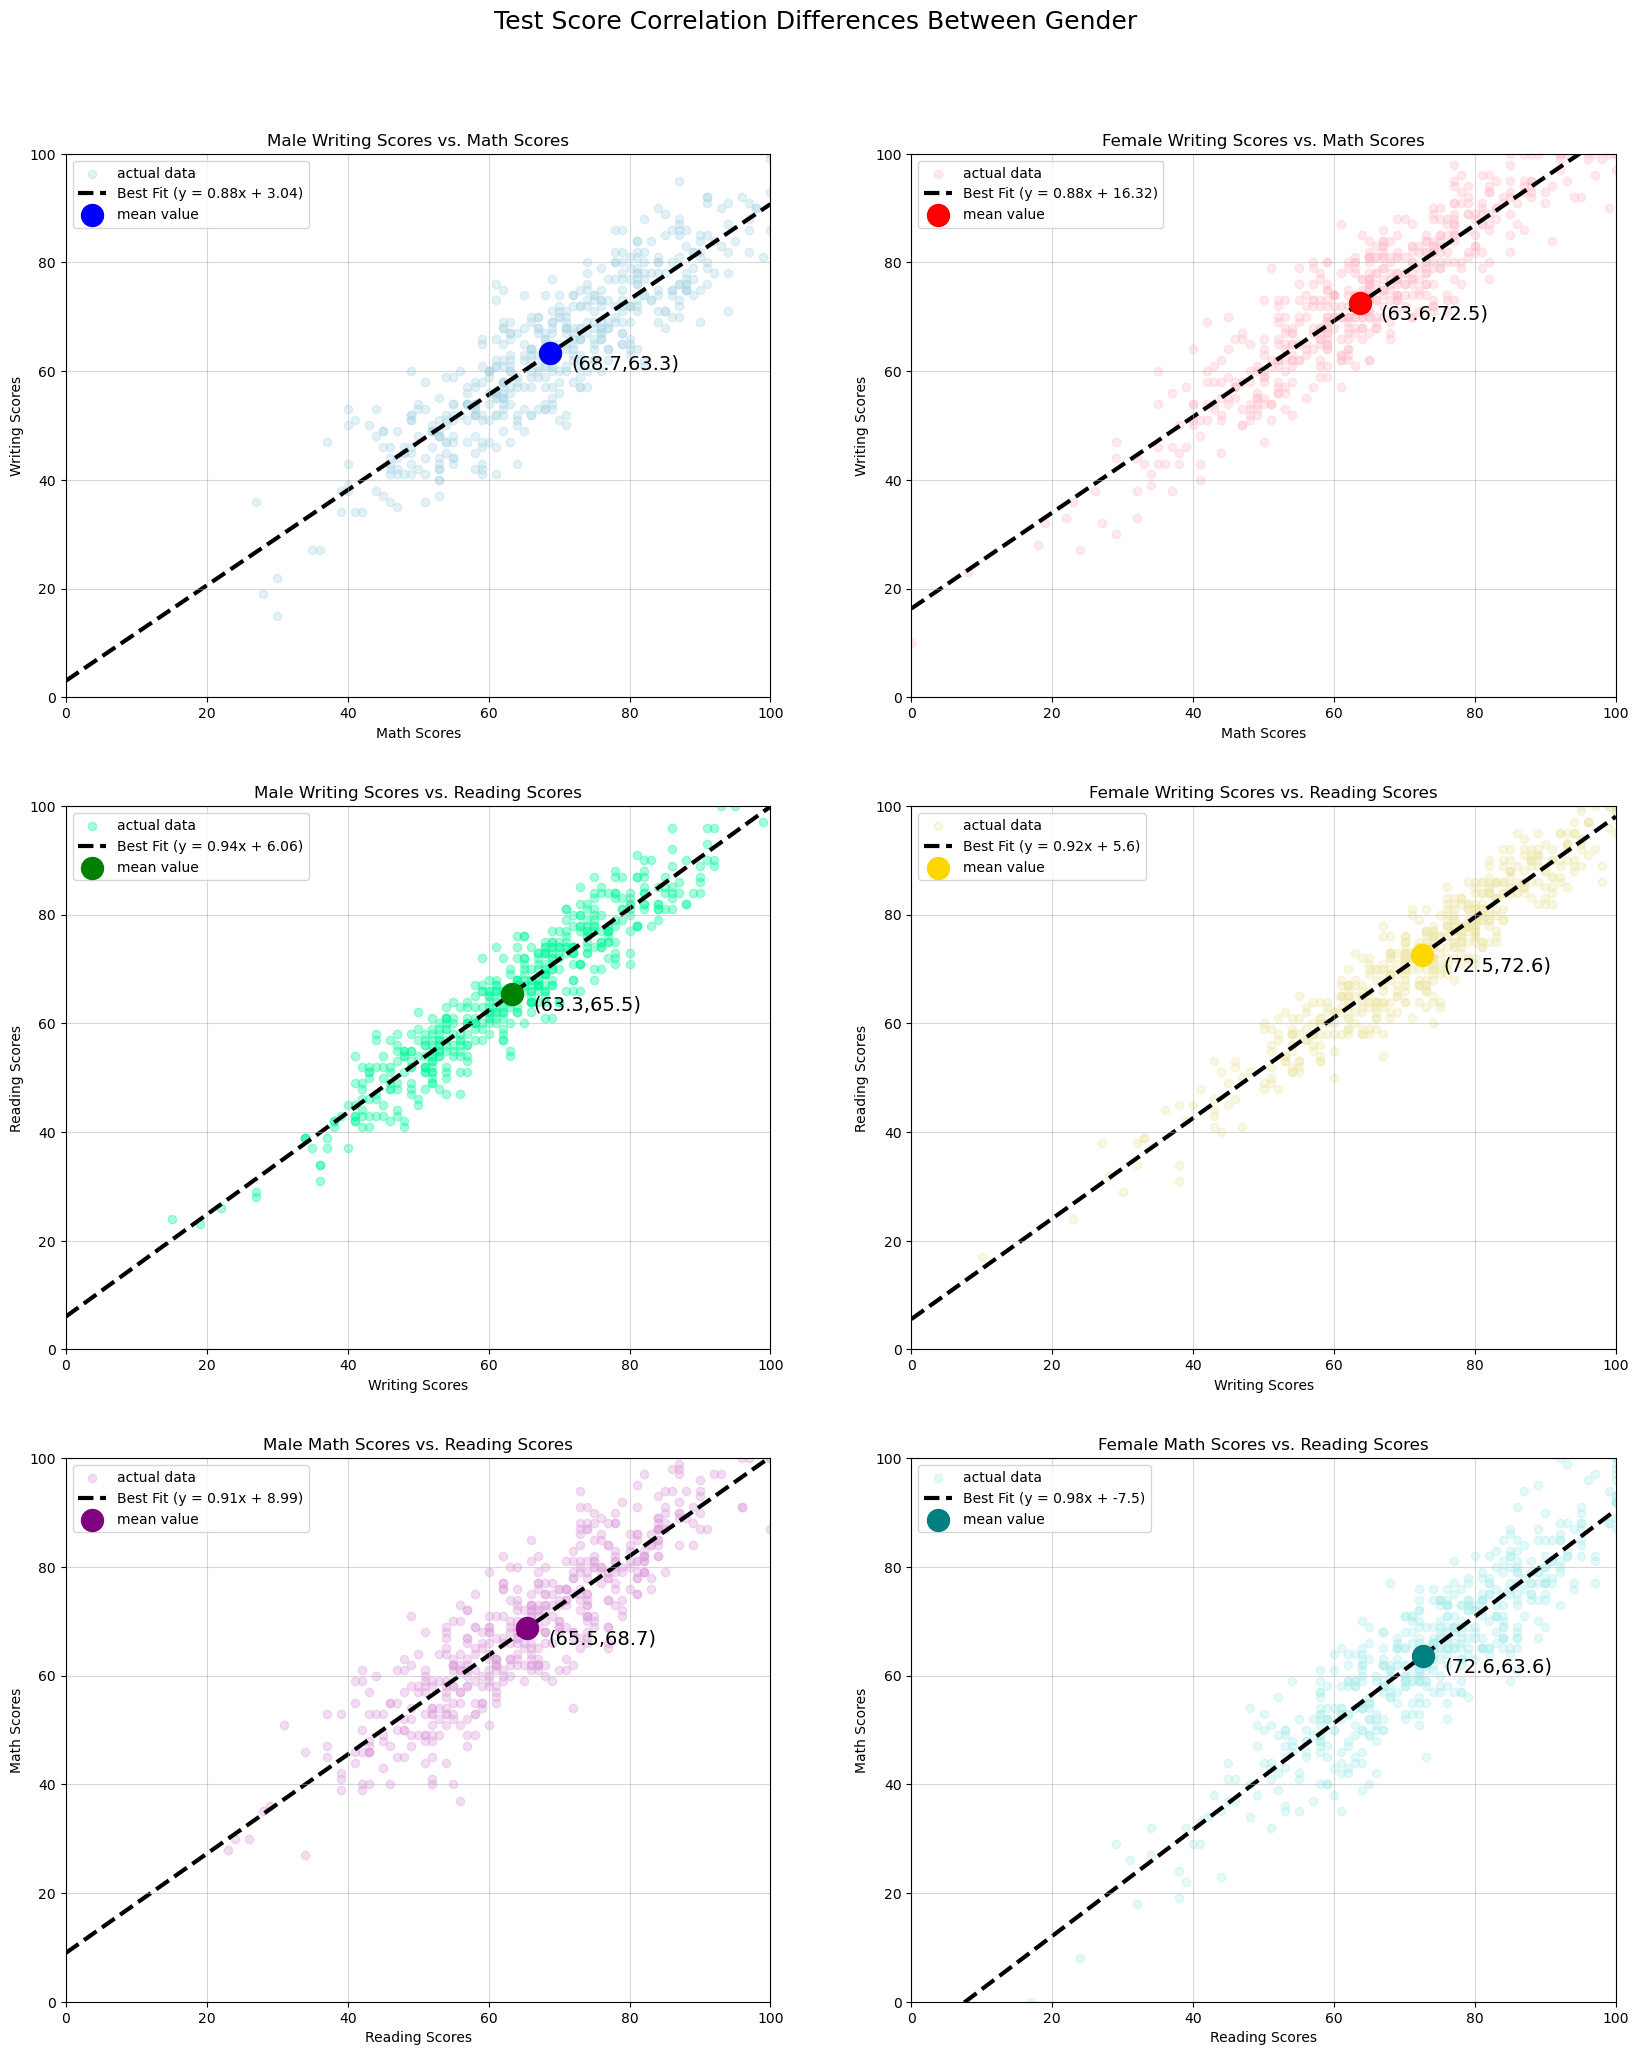

In [19]:
#initializng a 3x2 subplot figure for plotting the male and female regression lines
fig,axs = plt.subplots(nrows=3,ncols=2,figsize=(20,24))

#initializing a list of 3 sublists where each sublist contains the respective male and female x axis data for 
#each row of subplots
xs = [[male_math_scores,female_math_scores],[male_writing_scores,female_writing_scores],[male_reading_scores,female_reading_scores]]

#initializing a list of 3 sublists where each sublist contains the respective male and female y axis data for 
#each row of the subplots
ys = [[male_writing_scores,female_writing_scores],[male_reading_scores,female_reading_scores],[male_math_scores,female_math_scores]]

#initializing a list of 3 sublists where each sublist contians the respective male and female linear regression
#parameters for each row of the subplots 
para = [[male_math_writing_parameters,female_math_writing_parameters],[male_writing_reading_parameters,female_writing_reading_parameters],[male_reading_math_parameters,female_reading_math_parameters]]

#initializing a list of 3 sublists where each sublist contains the respective male and female subplot title
#for each row of the subplots
titles = [['Male Writing Scores vs. Math Scores','Female Writing Scores vs. Math Scores'],['Male Writing Scores vs. Reading Scores','Female Writing Scores vs. Reading Scores'],['Male Math Scores vs. Reading Scores','Female Math Scores vs. Reading Scores']]

#initializng a list of 3 tuples where each tuples contains the axis labels for that row of subplots 
axs_labels = [('Math Scores','Writing Scores'),('Writing Scores','Reading Scores'),('Reading Scores','Math Scores')]

#initializing a list of 3 sublists where each sublist contains the respective male and female mean value scatter 
#color for each row of the subplots
colors = [['blue','red'],['green','gold'],['purple','teal']]

#initializing a list of 3 sublists where each sublist contains the respective male and female scatter point 
#color for each row of the subplots
scattercolors = [['lightblue','pink'],['mediumspringgreen','palegoldenrod'],['plum','paleturquoise']]

#iterating over i = 0,1,2 where each i is a row of subplots
for i in range(3):
    
    #iterating over j = 0,1 where each j is a column of suplots 
    for j in range(2):
        
        #plotting the respective scatter plot for each of the 6 subplots using the already initialized lists
        axs[i,j].scatter(xs[i][j],ys[i][j],color=scattercolors[i][j],alpha=.35,label='actual data',zorder=-20)
        
        #plotting the respective linear regression line for each of the 6 subplots using the already
        #initialized lists
        axs[i,j].plot([0,max(xs[i][j])],[para[i][j][1],Linear(max(xs[i][j]),para[i][j][0],para[i][j][1])],color='black',
                      linewidth=3,linestyle='dashed',zorder=-10,label=f'Best Fit (y = {round(para[i][j][0],2)}x + {round(para[i][j][1],2)})')
        
        #plotting (x_mean, y_mean) for each of the 6 suplots using the already initialized lists 
        axs[i,j].scatter(np.mean(xs[i][j]),np.mean(ys[i][j]),marker='.',s=1000,color=colors[i][j],zorder=0,label='mean value')

        #adding an annotation including the values of the (x_mean,y_mean) coordinate for each of the 6 suplots
        axs[i,j].annotate(f'({round(np.mean(xs[i][j]),1)},{round(np.mean(ys[i][j]),1)})',xy=(np.mean(xs[i][j])+3,np.mean(ys[i][j])-3),fontsize=14)

        #setting the title of all 6 of the subplots using the titles list
        axs[i,j].set_title(titles[i][j])
            
        #setting the x axis label of all 6 of the subplots using the axs_labels list
        axs[i,j].set_xlabel(axs_labels[i][0]) 

        #setting the y axis label of all 6 of the subplots using the axs_labels list
        axs[i,j].set_ylabel(axs_labels[i][1]) 
           
        #setting a uniform x limit across all 6 of the subplots 
        axs[i,j].set_xlim(0,100)
    
        #setting a uniform y limit across all 6 of the subplots 
        axs[i,j].set_ylim(0,100)
    
        #initialzing a legend for each of the 6 subplots 
        axs[i,j].legend()
        
        #initializng a grid for each of the 6 subplots
        axs[i,j].grid(alpha=.5)

#setting the figure super title 
fig.suptitle('Test Score Correlation Differences Between Gender',y=.94,fontsize=18)

The subplots above are the visualization of the difference in sample means between the male and female students across the 3 subjects. 

In [20]:
#calculating the mae for the male writing v. math regression line 
male_math_writing_mae = calculate_mae(male_writing_scores,male_expected_writing_scores)

#calculating the mae for the male math v. reading regression line 
male_reading_math_mae = calculate_mae(male_math_scores,male_expected_math_scores)

#calculating the mae for the male reading v. writing regression line
male_writing_reading_mae = calculate_mae(male_reading_scores,male_expected_reading_scores)

#calculating the mae for the female writing v. math regression line
female_math_writing_mae = calculate_mae(female_writing_scores,female_expected_writing_scores)

#calculating the mae for the female math v. reading regression line
female_reading_math_mae = calculate_mae(female_math_scores,female_expected_math_scores)

#calculating the mae for the female reading v. writing regression line 
female_writing_reading_mae = calculate_mae(female_reading_scores,female_expected_reading_scores)

#displaying the mae values for all regression lines, male and female
print(f'The mae for the male writing v. math regression line is {round(male_math_writing_mae,2)}.\n\
The mae for the male math v. reading regression line is {round(male_reading_math_mae,2)}.\n\
The mae for the male reading v. writing regression line is {round(male_writing_reading_mae,2)}.\n\
The mae for the female writing v. math regression line is {round(female_math_writing_mae,2)}.\n\
The mae for the female math v. reading regression line is {round(female_reading_math_mae,2)}.\n\
The mae for the female reading v. writing regression line is {round(female_writing_reading_mae,2)}.')

The mae for the male writing v. math regression line is 5.12.
The mae for the male math v. reading regression line is 5.3.
The mae for the male reading v. writing regression line is 3.47.
The mae for the female writing v. math regression line is 4.62.
The mae for the female math v. reading regression line is 5.12.
The mae for the female reading v. writing regression line is 3.46.


By calculating the mae of the subgroups, we see that the claim of better fit data being the cause of high correlation is quantified. The mae of the writing/math and math/reading lines has decreased for both sexes while the reading/writing mae is more or less the same as before which is consisten with the correlation differences we have already highlighted. 

In [21]:
#finding expected male writing scores using the original unseparated parameters
male_writing_origfit = Linear(male_math_scores,math_writing_parameters[0],math_writing_parameters[1])

#finding the expected male reading scores using the original unseparated parameters
male_reading_origfit = Linear(male_writing_scores,writing_reading_parameters[0],writing_reading_parameters[1])

#finding the expected male math scores using the original unseparated parameters
male_math_origfit = Linear(male_reading_scores,reading_math_parameters[0],reading_math_parameters[1])

#finding the expected female writing scores using the original unseparated parameters
female_writing_origfit = Linear(female_math_scores,math_writing_parameters[0],math_writing_parameters[1])

#finding the expected female reading scores using the original unseparated parameters
female_reading_origfit = Linear(female_writing_scores,writing_reading_parameters[0],writing_reading_parameters[1])

#finding the expected female math scores using the original unseparated parameters 
female_math_origfit = Linear(female_reading_scores,reading_math_parameters[0],reading_math_parameters[1])

In [22]:
#calculating the mae for the male writing v. math line using the original fit parameters
male_writing_mae = calculate_mae(male_writing_scores,male_writing_origfit)

#calculating the mae for the male reading v. writing line using the original fit parameters
male_reading_mae = calculate_mae(male_reading_scores,male_reading_origfit)

#calculating the mae for the male math v. reading line using the original fit parameters
male_math_mae = calculate_mae(male_math_scores,male_math_origfit)

#calculating the mae for the female writing v. math line using the original fit parameters
female_writing_mae = calculate_mae(female_writing_scores,female_writing_origfit)

#calculating the mae for the female reading v. writing line using the original fit parameters
female_reading_mae = calculate_mae(female_reading_scores,female_reading_origfit)

#calculating the mae for the female math v. reading line using the original fit parameters
female_math_mae = calculate_mae(female_math_scores,female_math_origfit)

#displaying all the original fit mae's, male and female 
print(f'The mae for the males using the original writing v. math regression line is {round(male_writing_mae,2)}.\n\
The mae for the males using the original math v. reading regression line is {round(male_math_mae,2)}.\n\
The mae for the males using the original reading v. writing regression line is {round(male_reading_mae,2)}.\n\
The mae for the females using the original writing v. math regression line is {round(female_writing_mae,2)}.\n\
The mae for the females using the original math v. reading regression line is {round(female_math_mae,2)}.\n\
The mae for the females using the original reading v. writing regression line is {round(female_reading_mae,2)}.')

The mae for the males using the original writing v. math regression line is 7.85.
The mae for the males using the original math v. reading regression line is 7.19.
The mae for the males using the original reading v. writing regression line is 3.5.
The mae for the females using the original writing v. math regression line is 7.24.
The mae for the females using the original math v. reading regression line is 6.93.
The mae for the females using the original reading v. writing regression line is 3.45.


By finding the expected scores of each sex for each subject using the original parameters, we can see which group contributed more to the variance of the original data. We see that the female lines have less mae than the orinal data had while the males have greater mae. We can hypothesize that the male students increased the mae of the original data. 

### Ethnicity Analysis 

The intention of this ethnicity analysis is to answer the question of whether or not students of different ethnicity groups have different testing scores. We are purely looking to see if ethnicity affects a student's success not which ethnicty has better testing success. To eliminate bias in the data, the data does not include the specific ethnicity of each student, but rather what group they belong to (group A - group E).

In [23]:
#getting all unique ethnicities present in the dataset
ethnicities = [i for i in student_data['race/ethnicity'].unique()]

#sorting them alphabetically
ethnicities.sort()

#creating a list of mask where each mask finds the data with the corresponding ethnicity 
masks = [student_data['race/ethnicity'] == i for i in ethnicities]

#using the list of masks to create the 5 different subsets
groupA_data = student_data[masks[0]]

groupB_data = student_data[masks[1]]

groupC_data = student_data[masks[2]]

groupD_data = student_data[masks[3]]

groupE_data = student_data[masks[4]]

#bundling all the subsets into a list 
group_data = [groupA_data,groupB_data,groupC_data,groupD_data,groupE_data]

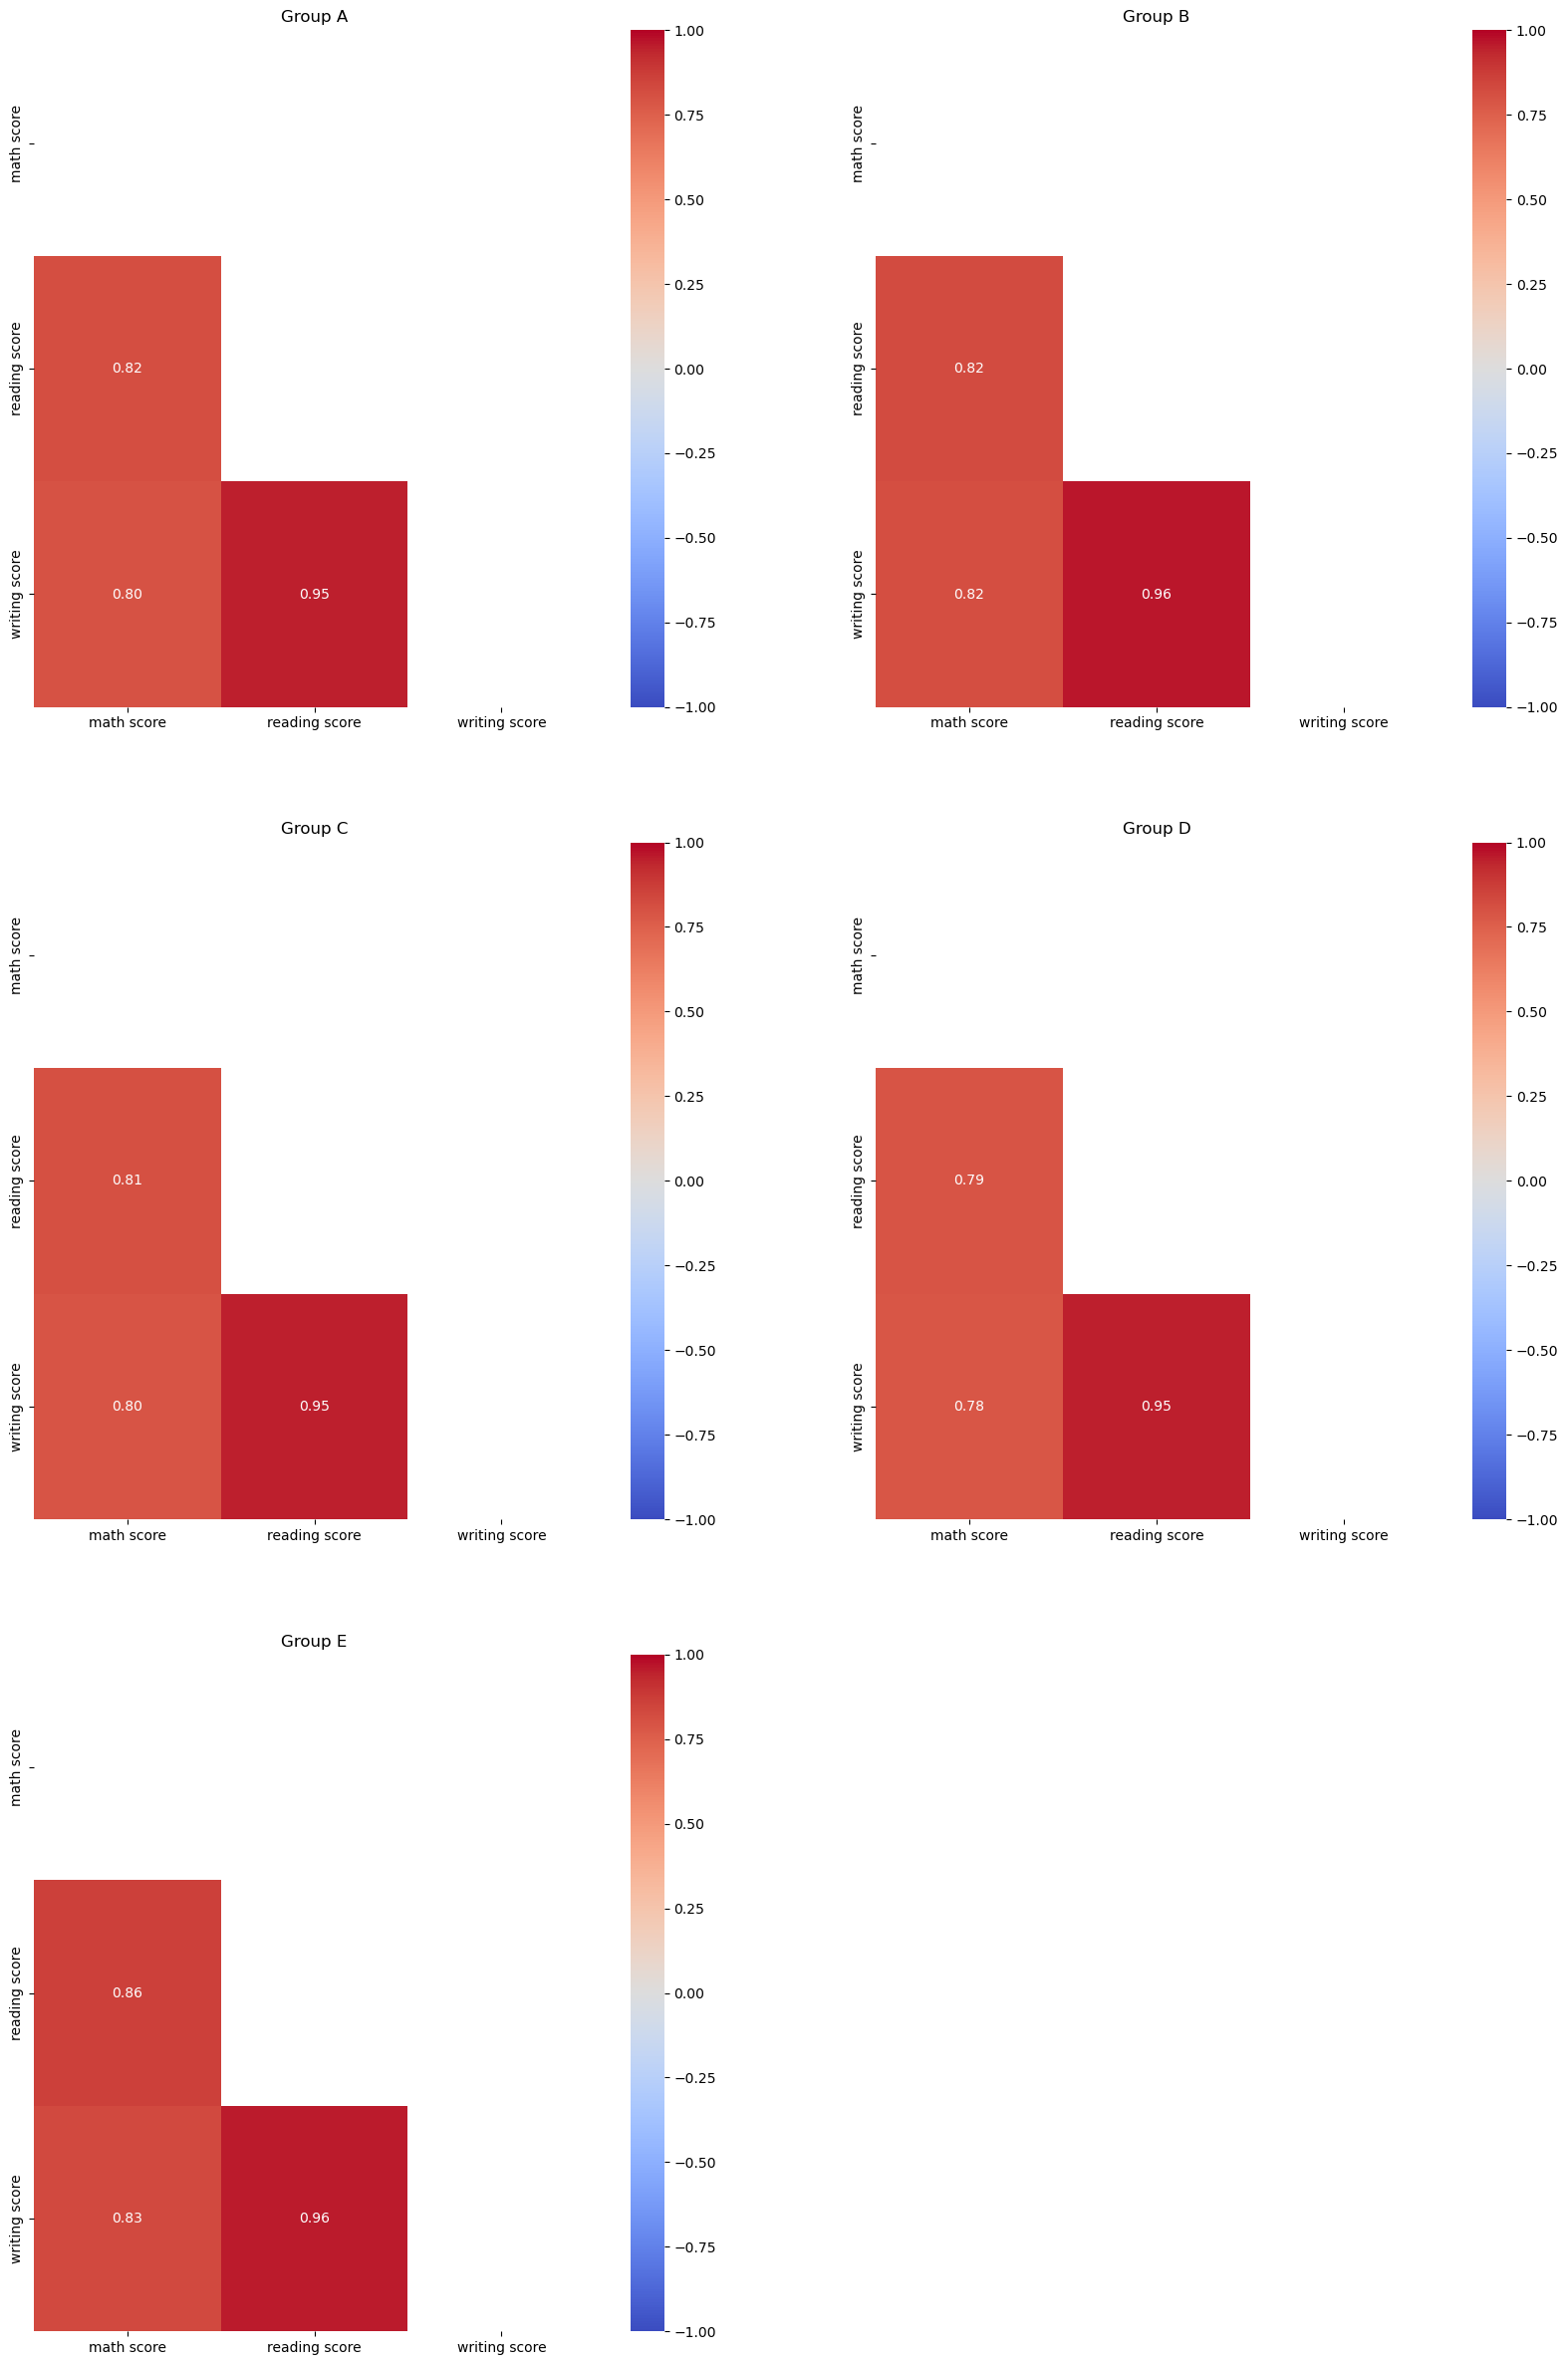

In [24]:
#getting correlation matrices for each ethnicity group in the dataset
matrices = [i.corr(numeric_only=True) for i in group_data]

#creating a mask to only show the lower triangle of each matrix
masks = [np.triu(np.ones_like(i, dtype=bool)) for i in matrices]

#creating a list of titles for each of the subplots 
titles = ['Group A','Group B','Group C','Group D','Group E']

#initializing figure to plot the matrices
fig, axs = plt.subplots(3,2,figsize=(20, 30))

#looping over the range of rows
for i in range(3):
    
    #looping over the range of columns 
    for j in range(2):
        
        #skipping over the 3rd row, 2nd column as there is only 5 matrices
        if i == 2 and j == 1:
            
            continue 
            
        else:
            
            #plotting correlation matrix for each of the ethnic groups 
            sns.heatmap(matrices[2*i + j], annot=True, vmin = -1, vmax = 1, fmt=".2f", cmap='coolwarm', mask=masks[2*i + j], ax=axs[i,j])
            
            #setting the title of each of the subplots 
            axs[i,j].set_title(titles[2*i + j])

#deleting the empty axis            
fig.delaxes(axs[2,1])

Here, we see the correlation matrix of each of the ethnicity groups. Some things to notice are that, once again, the correlation coefficient of reading/writing is virtually the same throughout and that we see less variation from the original full dataset correlation matrix than with the sex analysis. That is to say, ethnicity subgroups doesn't have as big an effect on the correlation matrix.

/Users/trentonsmiley/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x1000 with 0 Axes>

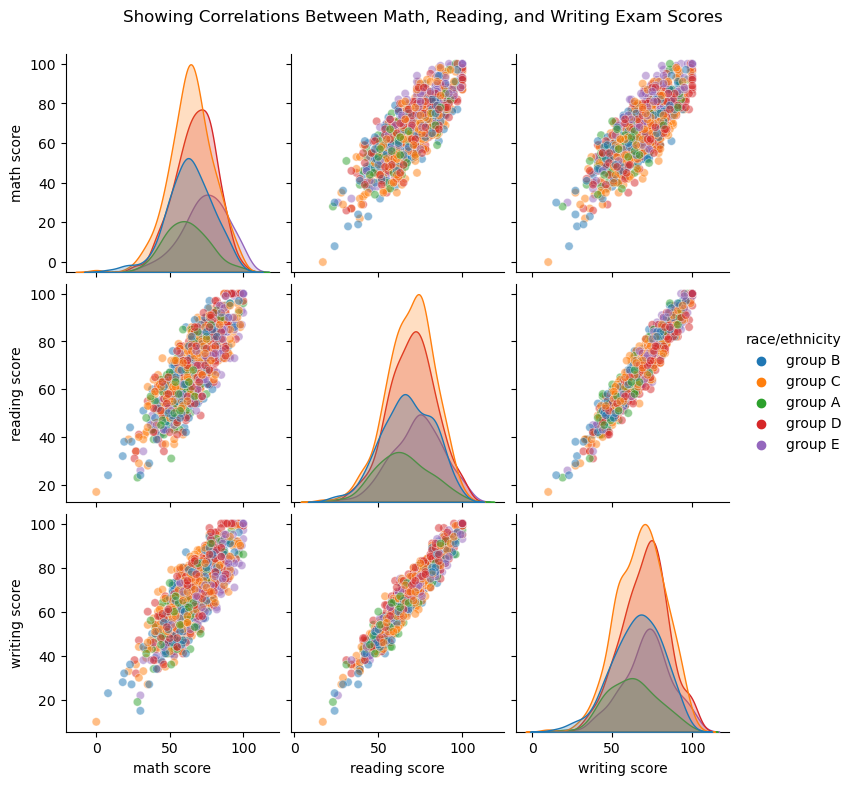

In [25]:
#recreating the numerical dataframe of the original student data
numerical_df = student_data.drop([i for i in student_data.columns if i not in ['math score','reading score','writing score','race/ethnicity']],axis=1)

#calling the figure constructer and setting figure size 
fig = plt.figure(figsize=(10,10))

#making a seaborn pairplot of the columns and calling parameters to customize it 
#this time we use the hue parameter to separate the data by gender
g = sns.pairplot(numerical_df,hue='race/ethnicity',diag_kind='kde',plot_kws={'color':'teal','alpha':0.5},diag_kws={'fill':True,'color':'teal'})

#setting the title of the figure
g.fig.suptitle('Showing Correlations Between Math, Reading, and Writing Exam Scores',y=1.04)

#saving the plot to files 
plt.savefig('Ethnicity Correlation.png')

The above plot is the pairplot of the data with each of the ethnicity groups showing up as a different color. This graph may be hard to read because of all of the intertwined colors, but looking at the histograms can give us an idea of the difference in scores between the plots. It is apparent that the means of the groups are different and the number of students represented by each group is different.

In [26]:
#initializing variables that hold the respective subject scores for each of the ethnicity groups 
groupA_math_scores, groupA_reading_scores, groupA_writing_scores = np.array(groupA_data['math score']), np.array(groupA_data['reading score']), np.array(groupA_data['writing score'])

groupB_math_scores, groupB_reading_scores, groupB_writing_scores = np.array(groupB_data['math score']), np.array(groupB_data['reading score']), np.array(groupB_data['writing score'])

groupC_math_scores, groupC_reading_scores, groupC_writing_scores = np.array(groupC_data['math score']), np.array(groupC_data['reading score']), np.array(groupC_data['writing score'])

groupD_math_scores, groupD_reading_scores, groupD_writing_scores = np.array(groupD_data['math score']), np.array(groupD_data['reading score']), np.array(groupD_data['writing score'])

groupE_math_scores, groupE_reading_scores, groupE_writing_scores = np.array(groupE_data['math score']), np.array(groupE_data['reading score']), np.array(groupE_data['writing score'])

#initializing variables for the number of students that belong to each of the ethnicity groups 
n_A, n_B, n_C, n_D, n_E = len(groupA_data), len(groupB_data), len(groupC_data), len(groupD_data), len(groupE_data) 

#initializing variables that hold the respective subject mean scores for each of the ethnicity groups 
groupA_math_mean, groupA_reading_mean, groupA_writing_mean = np.mean(groupA_math_scores), np.mean(groupA_reading_scores), np.mean(groupA_writing_scores)

groupB_math_mean, groupB_reading_mean, groupB_writing_mean = np.mean(groupB_math_scores), np.mean(groupB_reading_scores), np.mean(groupB_writing_scores)

groupC_math_mean, groupC_reading_mean, groupC_writing_mean = np.mean(groupC_math_scores), np.mean(groupC_reading_scores), np.mean(groupC_writing_scores)

groupD_math_mean, groupD_reading_mean, groupD_writing_mean = np.mean(groupD_math_scores), np.mean(groupD_reading_scores), np.mean(groupD_writing_scores)

groupE_math_mean, groupE_reading_mean, groupE_writing_mean = np.mean(groupE_math_scores), np.mean(groupE_reading_scores), np.mean(groupE_writing_scores)

#initializing variables that hold the respective subject standard deviation of scores for each of the ethnicity groups
groupA_math_std, groupA_reading_std, groupA_writing_std = np.std(groupA_math_scores), np.std(groupA_reading_scores), np.std(groupA_writing_scores)

groupB_math_std, groupB_reading_std, groupB_writing_std = np.std(groupB_math_scores), np.std(groupB_reading_scores), np.std(groupB_writing_scores)

groupC_math_std, groupC_reading_std, groupC_writing_std = np.std(groupC_math_scores), np.std(groupC_reading_scores), np.std(groupC_writing_scores)

groupD_math_std, groupD_reading_std, groupD_writing_std = np.std(groupD_math_scores), np.std(groupD_reading_scores), np.std(groupD_writing_scores)

groupE_math_std, groupE_reading_std, groupE_writing_std = np.std(groupE_math_scores), np.std(groupE_reading_scores), np.std(groupE_writing_scores)

In [26]:
#creating bunch tuples containing that contain the mean,standard deviation, and number of students for each of the ethnicity groups for each of the 3 subjects
math_scores = [(groupA_math_mean,groupA_math_std,n_A),(groupB_math_mean,groupB_math_std,n_B),(groupC_math_mean,groupC_math_std,n_C),(groupD_math_mean,groupD_math_std,n_D),(groupE_math_mean,groupE_math_std,n_E)]

reading_scores = [(groupA_reading_mean,groupA_reading_std,n_A),(groupB_reading_mean,groupB_reading_std,n_B),(groupC_reading_mean,groupC_reading_std,n_C),(groupD_reading_mean,groupD_reading_std,n_D),(groupE_reading_mean,groupE_reading_std,n_E)]

writing_scores = [(groupA_writing_mean,groupA_writing_std,n_A),(groupB_writing_mean,groupB_writing_std,n_B),(groupC_writing_mean,groupC_writing_std,n_C),(groupD_writing_mean,groupD_writing_std,n_D),(groupE_writing_mean,groupE_writing_std,n_E)]

#creating a list that contains all 3 subjects of bunch tuples 
scores = [math_scores,reading_scores,writing_scores]

#creating a list of subject strings 
subjects = ['Math','Reading','Writing']

#creating a list of the different ethnicity groups
groups = ['A','B','C','D','E']

#initializing empty list to be filled with p-value matrix for each of the subjects
scores_matrices = []

#iterating over the different subject score lists 
for i in scores:
    
    #initializing a variable for the average z-score and p-value 
    average_z = 0

    average_p = 0 
    
    #initializing an all zero 2d numpy array of shape 5x5
    matrix = np.zeros((5,5))
    
    #print the subject for which we are displaying the z-test result
    print(f'{subjects[scores.index(i)]}:\n')
    
    #iterating over the different group tuples (groupA - groupE)
    for j in range(len(i)):
        
        #iterating over the other groups to perform all possible z-test permutations without repeating
        for k in range(j+1,len(i)):
            
            #performing the 2-sample Z-test 
            z, p = twoSampZ(i[j][0],i[k][0],0,i[j][1],i[k][1],i[j][2],i[k][2])
            
            #updating the value of the average values of z and p 
            average_z += abs(z)

            average_p += abs(p)
            
            #setting the corresponding indices in the matrix equal to the p-value
            matrix[j,k] = p; matrix[k,j] = p
            
            #displaying the results
            print(f'For Group {groups[j]} v. Group {groups[k]}: the z-score and corresponding p-value is {round(z,2)} and {p:.3g}.')
        
        #setting the diagonal of the matrix equal to 1 because it is a z-test between identical samples
        matrix[j,j] = 1
    
    #displaying the average z-score and p-value for the subject across all groups 
    print(f'The average z-score and corresponding p-value for all groups is {round(average_z/10,2)} and {average_p/10:.3g}.\n')
    
    #appending the p-value matrix to the list of matrices 
    scores_matrices.append(matrix)

Math:

For Group A v. Group B: the z-score and corresponding p-value is -0.96 and 0.336.
For Group A v. Group C: the z-score and corresponding p-value is -1.63 and 0.104.
For Group A v. Group D: the z-score and corresponding p-value is -3.28 and 0.0011.
For Group A v. Group E: the z-score and corresponding p-value is -6.06 and 0.
For Group B v. Group C: the z-score and corresponding p-value is -0.73 and 0.468.
For Group B v. Group D: the z-score and corresponding p-value is -2.78 and 0.0054.
For Group B v. Group E: the z-score and corresponding p-value is -6.02 and 0.
For Group C v. Group D: the z-score and corresponding p-value is -2.44 and 0.0147.
For Group C v. Group E: the z-score and corresponding p-value is -6.04 and 0.
For Group D v. Group E: the z-score and corresponding p-value is -4.14 and 0.
The average z-score and corresponding p-value for all groups is 3.41 and 0.0929.

Reading:

For Group A v. Group B: the z-score and corresponding p-value is -1.36 and 0.174.
For Group A 

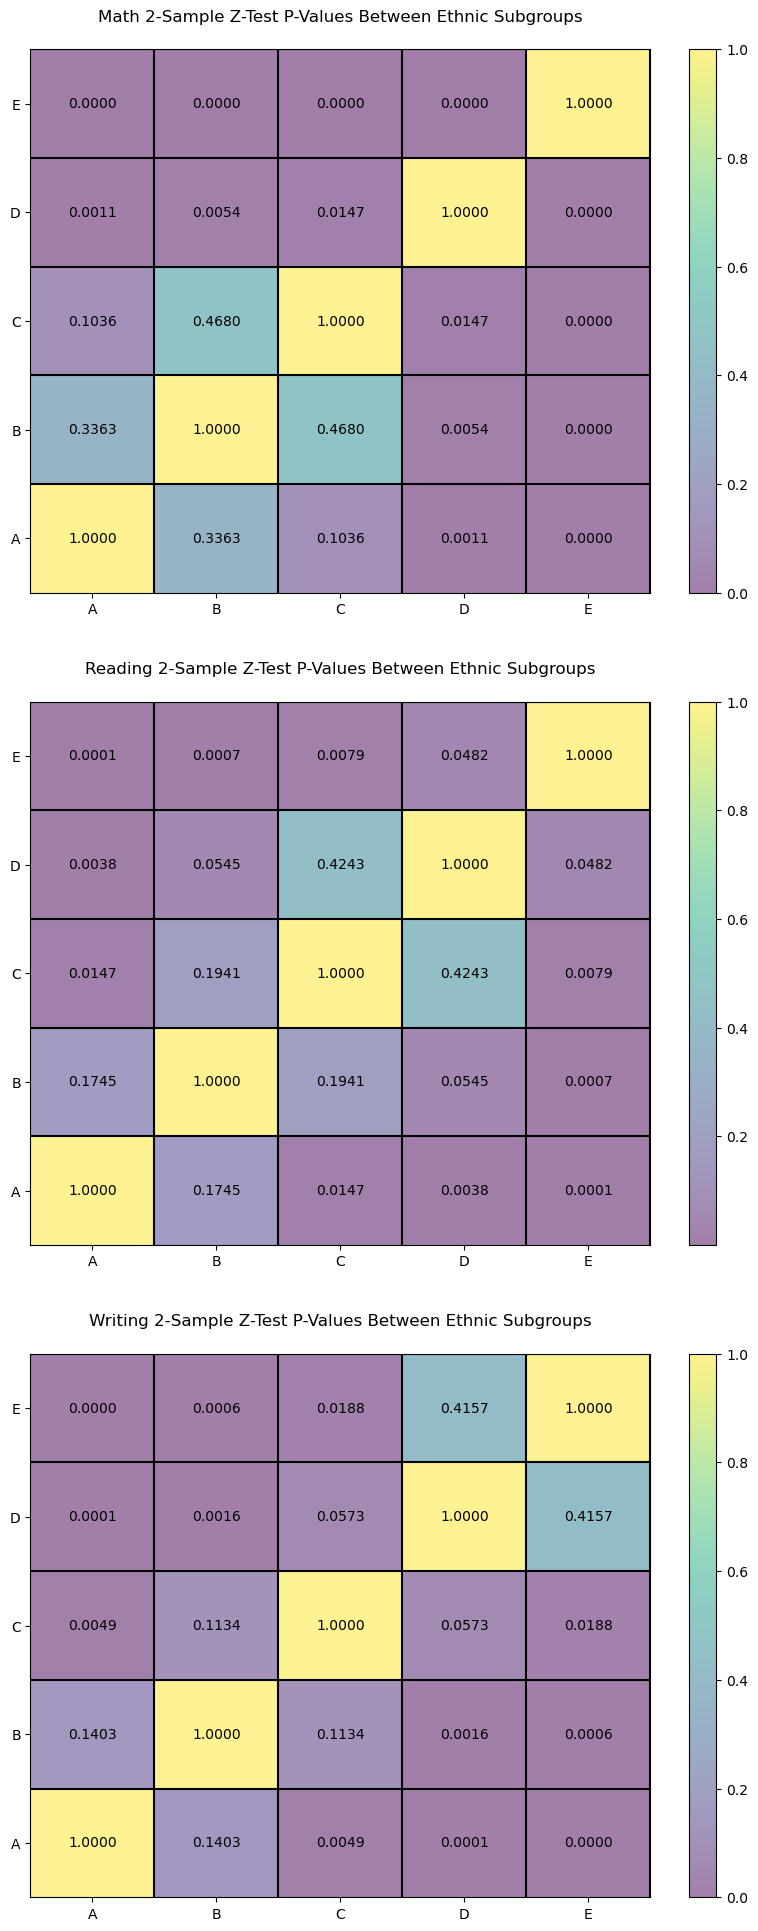

In [27]:
#creating a list of a the subjects  
subjects = ['Math','Reading','Writing']

#initializing the plotting figure 
fig, axs = plt.subplots(nrows=3,figsize=(10,24))

#iterating over the matrices
for i in range(3):
    
    #plotting a colormesh grid of the selected matrix 
    grid = axs[i].pcolormesh(scores_matrices[i],alpha=.5)

    #plotting a colorbar
    plt.colorbar(grid, ax=axs[i])

    #setting the x and y ticks to show what groups are being compared at each tile 
    axs[i].set_xticks(ticks=np.arange(.5,5,1),labels=['A','B','C','D','E'])

    axs[i].set_yticks(ticks=np.arange(.5,5,1),labels=['A','B','C','D','E'])

    #iterating over the x and y values in the grid
    for j in range(1,6):

        #using the vertical line and horizontal line functions to plot grid lines separating the tiles 
        axs[i].axhline(j,color='black')

        axs[i].axvline(j,color='black')
    
    #iterating over the y values corresponding the to number of rows in the matrix
    for y in range(scores_matrices[i].shape[0]):

        #iterating over the x values corresponding the to number of columns in the matrix
        for x in range(scores_matrices[i].shape[1]):

            #annotating the matrix to show the p-value on each tile
            axs[i].text(x + 0.5, y + 0.5, '%.4f' % scores_matrices[i][y, x], horizontalalignment='center', verticalalignment='center')
    
    #setting the title of each of the subplots 
    axs[i].set_title(f'{subjects[i]} 2-Sample Z-Test P-Values Between Ethnic Subgroups',pad=20)

The above matrices give a lot of information about the difference in ehtnic subgroups for each subject. Consistent across all subjects, groups A, B, and C have a p-value below the significance level when testing with group E. Group D and E have an insignificant difference when looking only at writing scores. Across all subejcts, groups A, C have a p-value above the significance level when compared with group B. C and A are only insignificant when looking at math scores. C and D are only significant when looking at math scores. In order to find out why some groups are significant when compared to some, but not others, we have to do analysis of the expectations of scores for each subgroups.  

In [28]:
#creating a list of each of the subsets of the respective subject scores for each of the ethnicity groups 
math_scores = [groupA_math_scores,groupB_math_scores,groupC_math_scores,groupD_math_scores,groupE_math_scores]

reading_scores = [groupA_reading_scores,groupB_reading_scores,groupC_reading_scores,groupD_reading_scores,groupE_reading_scores]

writing_scores = [groupA_writing_scores,groupB_writing_scores,groupC_writing_scores,groupD_writing_scores,groupE_writing_scores]

#bunching the subject lists into one list 
scores = [math_scores,reading_scores,writing_scores]

#initialzing a list with each of the subject name strings
subjects = ['Math','Reading','Writing']

#initializing an empty list to hold the p-value matrices
scores_matrices = []

#iterating over the different subject score lists
for i in range(len(scores)):
    
    #initializng variables to hold the average t-statistic and p-value
    average_t = 0

    average_p = 0 
    
    #initializng a 2d numpy array of shape 5x5
    matrix = np.zeros((5,5))
    
    #printing the subject of which the 2-sample T-test is being performed
    print(f'{subjects[i]}:\n')
    
    #iterating over the different group tuples (groupA - groupE)
    for j in range(len(scores[i])):
        
        #iterating over the other groups to perform all possible t-test permutations without repeating
        for k in range(j+1,len(scores[i])):

            #performing the 2-sample independent T-test
            t, p = ttest(scores[i][j],scores[i][k],equal_var=False)

            #updating the values for the average t-statistic and p-value 
            average_t += abs(t)

            average_p += abs(p)
            
            #setting the corresponding indices in the matrix equal to the p-value
            matrix[j,k] = p; matrix[k,j] = p
            
            #displaying the results 
            print(f'For Group {groups[j]} v. Group {groups[k]}: the t-statistic and corresponding p-value is {round(t,2)} and {p:.3g}.')
    
        #setting the diagonal of the matrix equal to 1 because it is a z-test between identical samples
        matrix[j,j] = 1
    
    #displaying the average t-statistic and p-value for each subject
    print(f'The average t-statistic and corresponding p-value for all groups is {round(average_t/10,2)} and {average_p/10:.3g}.\n')
      
    #appending the matrix to the list of matrices 
    scores_matrices.append(matrix)
    
    

Math:

For Group A v. Group B: the t-statistic and corresponding p-value is -0.96 and 0.34.
For Group A v. Group C: the t-statistic and corresponding p-value is -1.62 and 0.107.
For Group A v. Group D: the t-statistic and corresponding p-value is -3.26 and 0.00139.
For Group A v. Group E: the t-statistic and corresponding p-value is -6.03 and 8.14e-09.
For Group B v. Group C: the t-statistic and corresponding p-value is -0.72 and 0.469.
For Group B v. Group D: the t-statistic and corresponding p-value is -2.78 and 0.00577.
For Group B v. Group E: the t-statistic and corresponding p-value is -6.0 and 5.59e-09.
For Group C v. Group D: the t-statistic and corresponding p-value is -2.44 and 0.0151.
For Group C v. Group E: the t-statistic and corresponding p-value is -6.02 and 6.01e-09.
For Group D v. Group E: the t-statistic and corresponding p-value is -4.13 and 4.94e-05.
The average t-statistic and corresponding p-value for all groups is 3.4 and 0.0939.

Reading:

For Group A v. Group B:

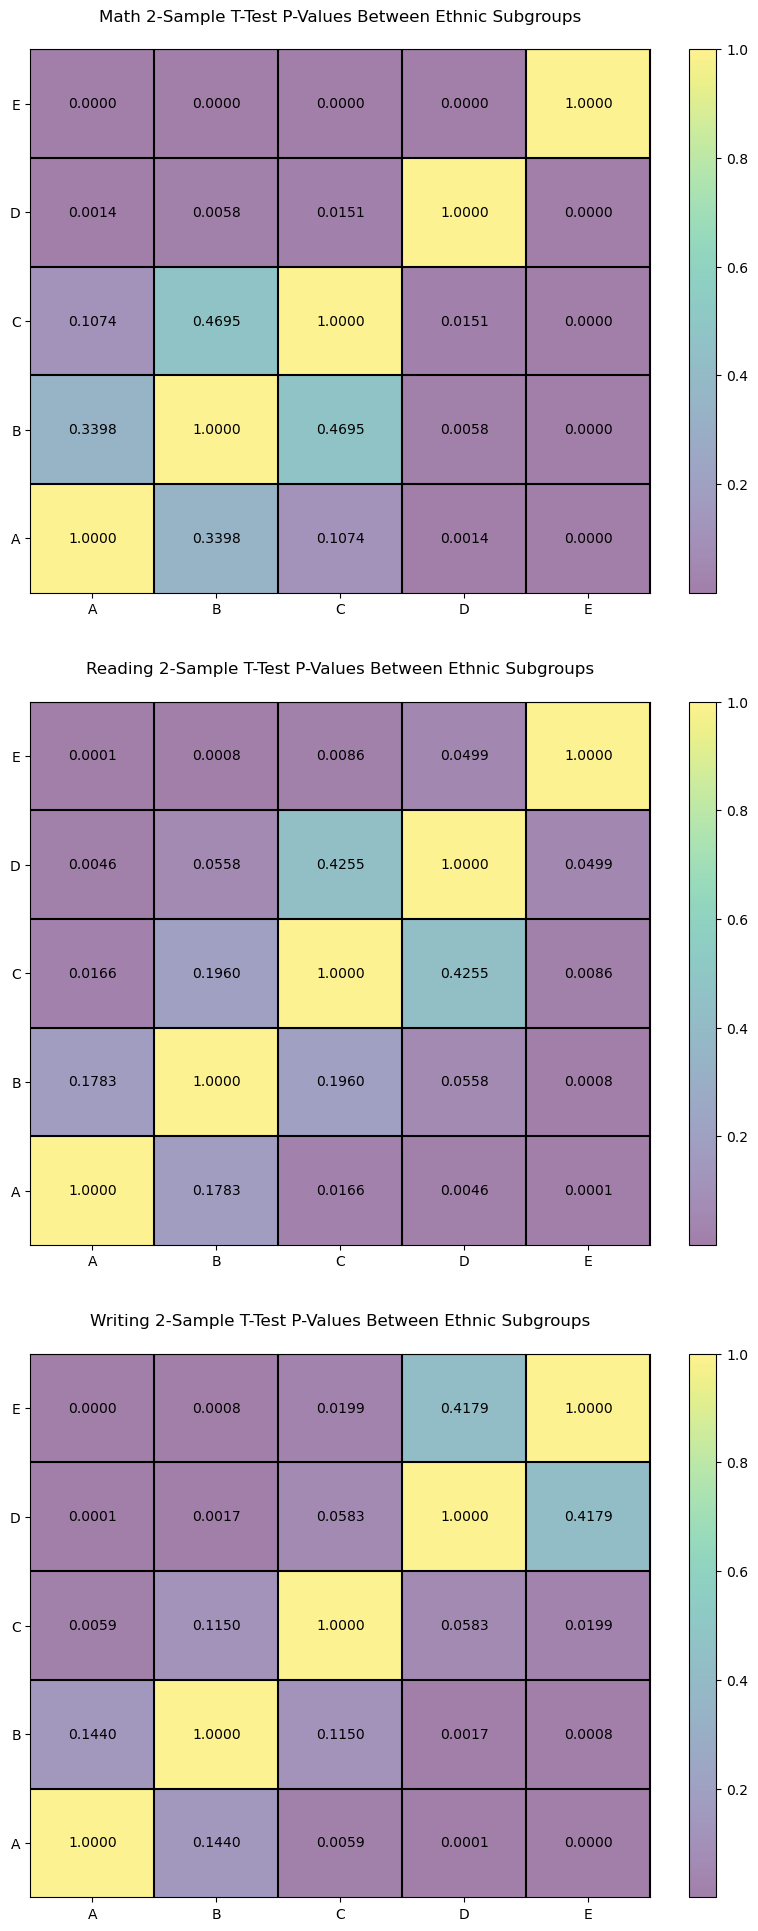

In [29]:
#creating a list of subjects
subjects = ['Math','Reading','Writing']

#intializing the plot figure
fig, axs = plt.subplots(nrows=3,figsize=(10,24))

#iterating over the matrices
for i in range(3):
    
    #plotting the color meshgrid 
    grid = axs[i].pcolormesh(scores_matrices[i],alpha=.5)

    #plotting the colorbar
    plt.colorbar(grid, ax=axs[i])

    #setting the x and y ticks to show what groups are being compared at each tile
    axs[i].set_xticks(ticks=np.arange(.5,5,1),labels=['A','B','C','D','E'])

    axs[i].set_yticks(ticks=np.arange(.5,5,1),labels=['A','B','C','D','E'])
    
    #iterating over the x and y values in the grid
    for j in range(1,6):

        #plotting the grid lines using the horizontal and vertical line functions 
        axs[i].axhline(j,color='black')

        axs[i].axvline(j,color='black')

    #iterating over the y values corresponding to the matrix rows
    for y in range(scores_matrices[i].shape[0]):

        #iterative over the x values corresponding to the matrix columns 
        for x in range(scores_matrices[i].shape[1]):

            #annotating the grid to show the p-value at each tile 
            axs[i].text(x + 0.5, y + 0.5, '%.4f' % scores_matrices[i][y, x], horizontalalignment='center', verticalalignment='center')
    
    #setting the title of each subplot 
    axs[i].set_title(f'{subjects[i]} 2-Sample T-Test P-Values Between Ethnic Subgroups',pad=20)

The t-test matrices above are used to reinforce the findings from the z-test and to check for consistency in the p-values which we see. 

In [30]:
#finding the linear parameters of the male writing v. math regression line
groupA_math_writing_parameters, _ = curve_fit(Linear,groupA_math_scores,groupA_writing_scores)

#finding the linear parameters of the male math v. reading regression line  
groupA_reading_math_parameters, _ = curve_fit(Linear,groupA_reading_scores,groupA_math_scores)

#finding the linear parameters of the male reading v. writing regression line 
groupA_writing_reading_parameters, _ = curve_fit(Linear,groupA_writing_scores,groupA_reading_scores)

#using the male writing v. math parameters with the linear model to find the expected male writing scores 
groupA_expected_writing_scores = Linear(groupA_math_scores,groupA_math_writing_parameters[0],groupA_math_writing_parameters[1])

#using the male math v. reading parameters with the linear model to find the expected male math scores 
groupA_expected_math_scores = Linear(groupA_reading_scores,groupA_reading_math_parameters[0],groupA_reading_math_parameters[1])

#using the male reading v. writing parameters with the linear model to find the expected male reading scores 
groupA_expected_reading_scores = Linear(groupA_writing_scores,groupA_writing_reading_parameters[0],groupA_writing_reading_parameters[1])

#finding the linear parameters of the female writing v. math regression line 
groupB_math_writing_parameters, _ = curve_fit(Linear,groupB_math_scores,groupB_writing_scores)

#finding the linear parameters of the female math v. reading regression line 
groupB_reading_math_parameters, _ = curve_fit(Linear,groupB_reading_scores,groupB_math_scores)

#finding the linear parameters of the female reading v. writing regression line 
groupB_writing_reading_parameters, _ = curve_fit(Linear,groupB_writing_scores,groupB_reading_scores)

#using the female writing v. math parameters with the linear model to find the expected female writing scores 
groupB_expected_writing_scores = Linear(groupB_math_scores,groupB_math_writing_parameters[0],groupB_math_writing_parameters[1])

#using the female math v. reading parameters with the linear model to find the expected female math scores
groupB_expected_math_scores = Linear(groupB_reading_scores,groupB_reading_math_parameters[0],groupB_reading_math_parameters[1])

#using the female reading v. writing parameters with the linear model to find the expected female reading scores
groupB_expected_reading_scores = Linear(groupB_writing_scores,groupB_writing_reading_parameters[0],groupB_writing_reading_parameters[1])

#finding the linear parameters of the male writing v. math regression line
groupC_math_writing_parameters, _ = curve_fit(Linear,groupC_math_scores,groupC_writing_scores)

#finding the linear parameters of the male math v. reading regression line  
groupC_reading_math_parameters, _ = curve_fit(Linear,groupC_reading_scores,groupC_math_scores)

#finding the linear parameters of the male reading v. writing regression line 
groupC_writing_reading_parameters, _ = curve_fit(Linear,groupC_writing_scores,groupC_reading_scores)

#using the male writing v. math parameters with the linear model to find the expected male writing scores 
groupC_expected_writing_scores = Linear(groupC_math_scores,groupC_math_writing_parameters[0],groupC_math_writing_parameters[1])

#using the male math v. reading parameters with the linear model to find the expected male math scores 
groupC_expected_math_scores = Linear(groupC_reading_scores,groupC_reading_math_parameters[0],groupC_reading_math_parameters[1])

#using the male reading v. writing parameters with the linear model to find the expected male reading scores 
groupC_expected_reading_scores = Linear(groupC_writing_scores,groupC_writing_reading_parameters[0],groupC_writing_reading_parameters[1])

#finding the linear parameters of the female writing v. math regression line 
groupD_math_writing_parameters, _ = curve_fit(Linear,groupD_math_scores,groupD_writing_scores)

#finding the linear parameters of the female math v. reading regression line 
groupD_reading_math_parameters, _ = curve_fit(Linear,groupD_reading_scores,groupD_math_scores)

#finding the linear parameters of the female reading v. writing regression line 
groupD_writing_reading_parameters, _ = curve_fit(Linear,groupD_writing_scores,groupD_reading_scores)

#using the female writing v. math parameters with the linear model to find the expected female writing scores 
groupD_expected_writing_scores = Linear(groupD_math_scores,groupD_math_writing_parameters[0],groupD_math_writing_parameters[1])

#using the female math v. reading parameters with the linear model to find the expected female math scores
groupD_expected_math_scores = Linear(groupD_reading_scores,groupD_reading_math_parameters[0],groupD_reading_math_parameters[1])

#using the female reading v. writing parameters with the linear model to find the expected female reading scores
groupD_expected_reading_scores = Linear(groupD_writing_scores,groupD_writing_reading_parameters[0],groupD_writing_reading_parameters[1])

#finding the linear parameters of the female writing v. math regression line 
groupE_math_writing_parameters, _ = curve_fit(Linear,groupE_math_scores,groupE_writing_scores)

#finding the linear parameters of the female math v. reading regression line 
groupE_reading_math_parameters, _ = curve_fit(Linear,groupE_reading_scores,groupE_math_scores)

#finding the linear parameters of the female reading v. writing regression line 
groupE_writing_reading_parameters, _ = curve_fit(Linear,groupE_writing_scores,groupE_reading_scores)

#using the female writing v. math parameters with the linear model to find the expected female writing scores 
groupE_expected_writing_scores = Linear(groupE_math_scores,groupE_math_writing_parameters[0],groupE_math_writing_parameters[1])

#using the female math v. reading parameters with the linear model to find the expected female math scores
groupE_expected_math_scores = Linear(groupE_reading_scores,groupE_reading_math_parameters[0],groupE_reading_math_parameters[1])

#using the female reading v. writing parameters with the linear model to find the expected female reading scores
groupE_expected_reading_scores = Linear(groupE_writing_scores,groupE_writing_reading_parameters[0],groupE_writing_reading_parameters[1])

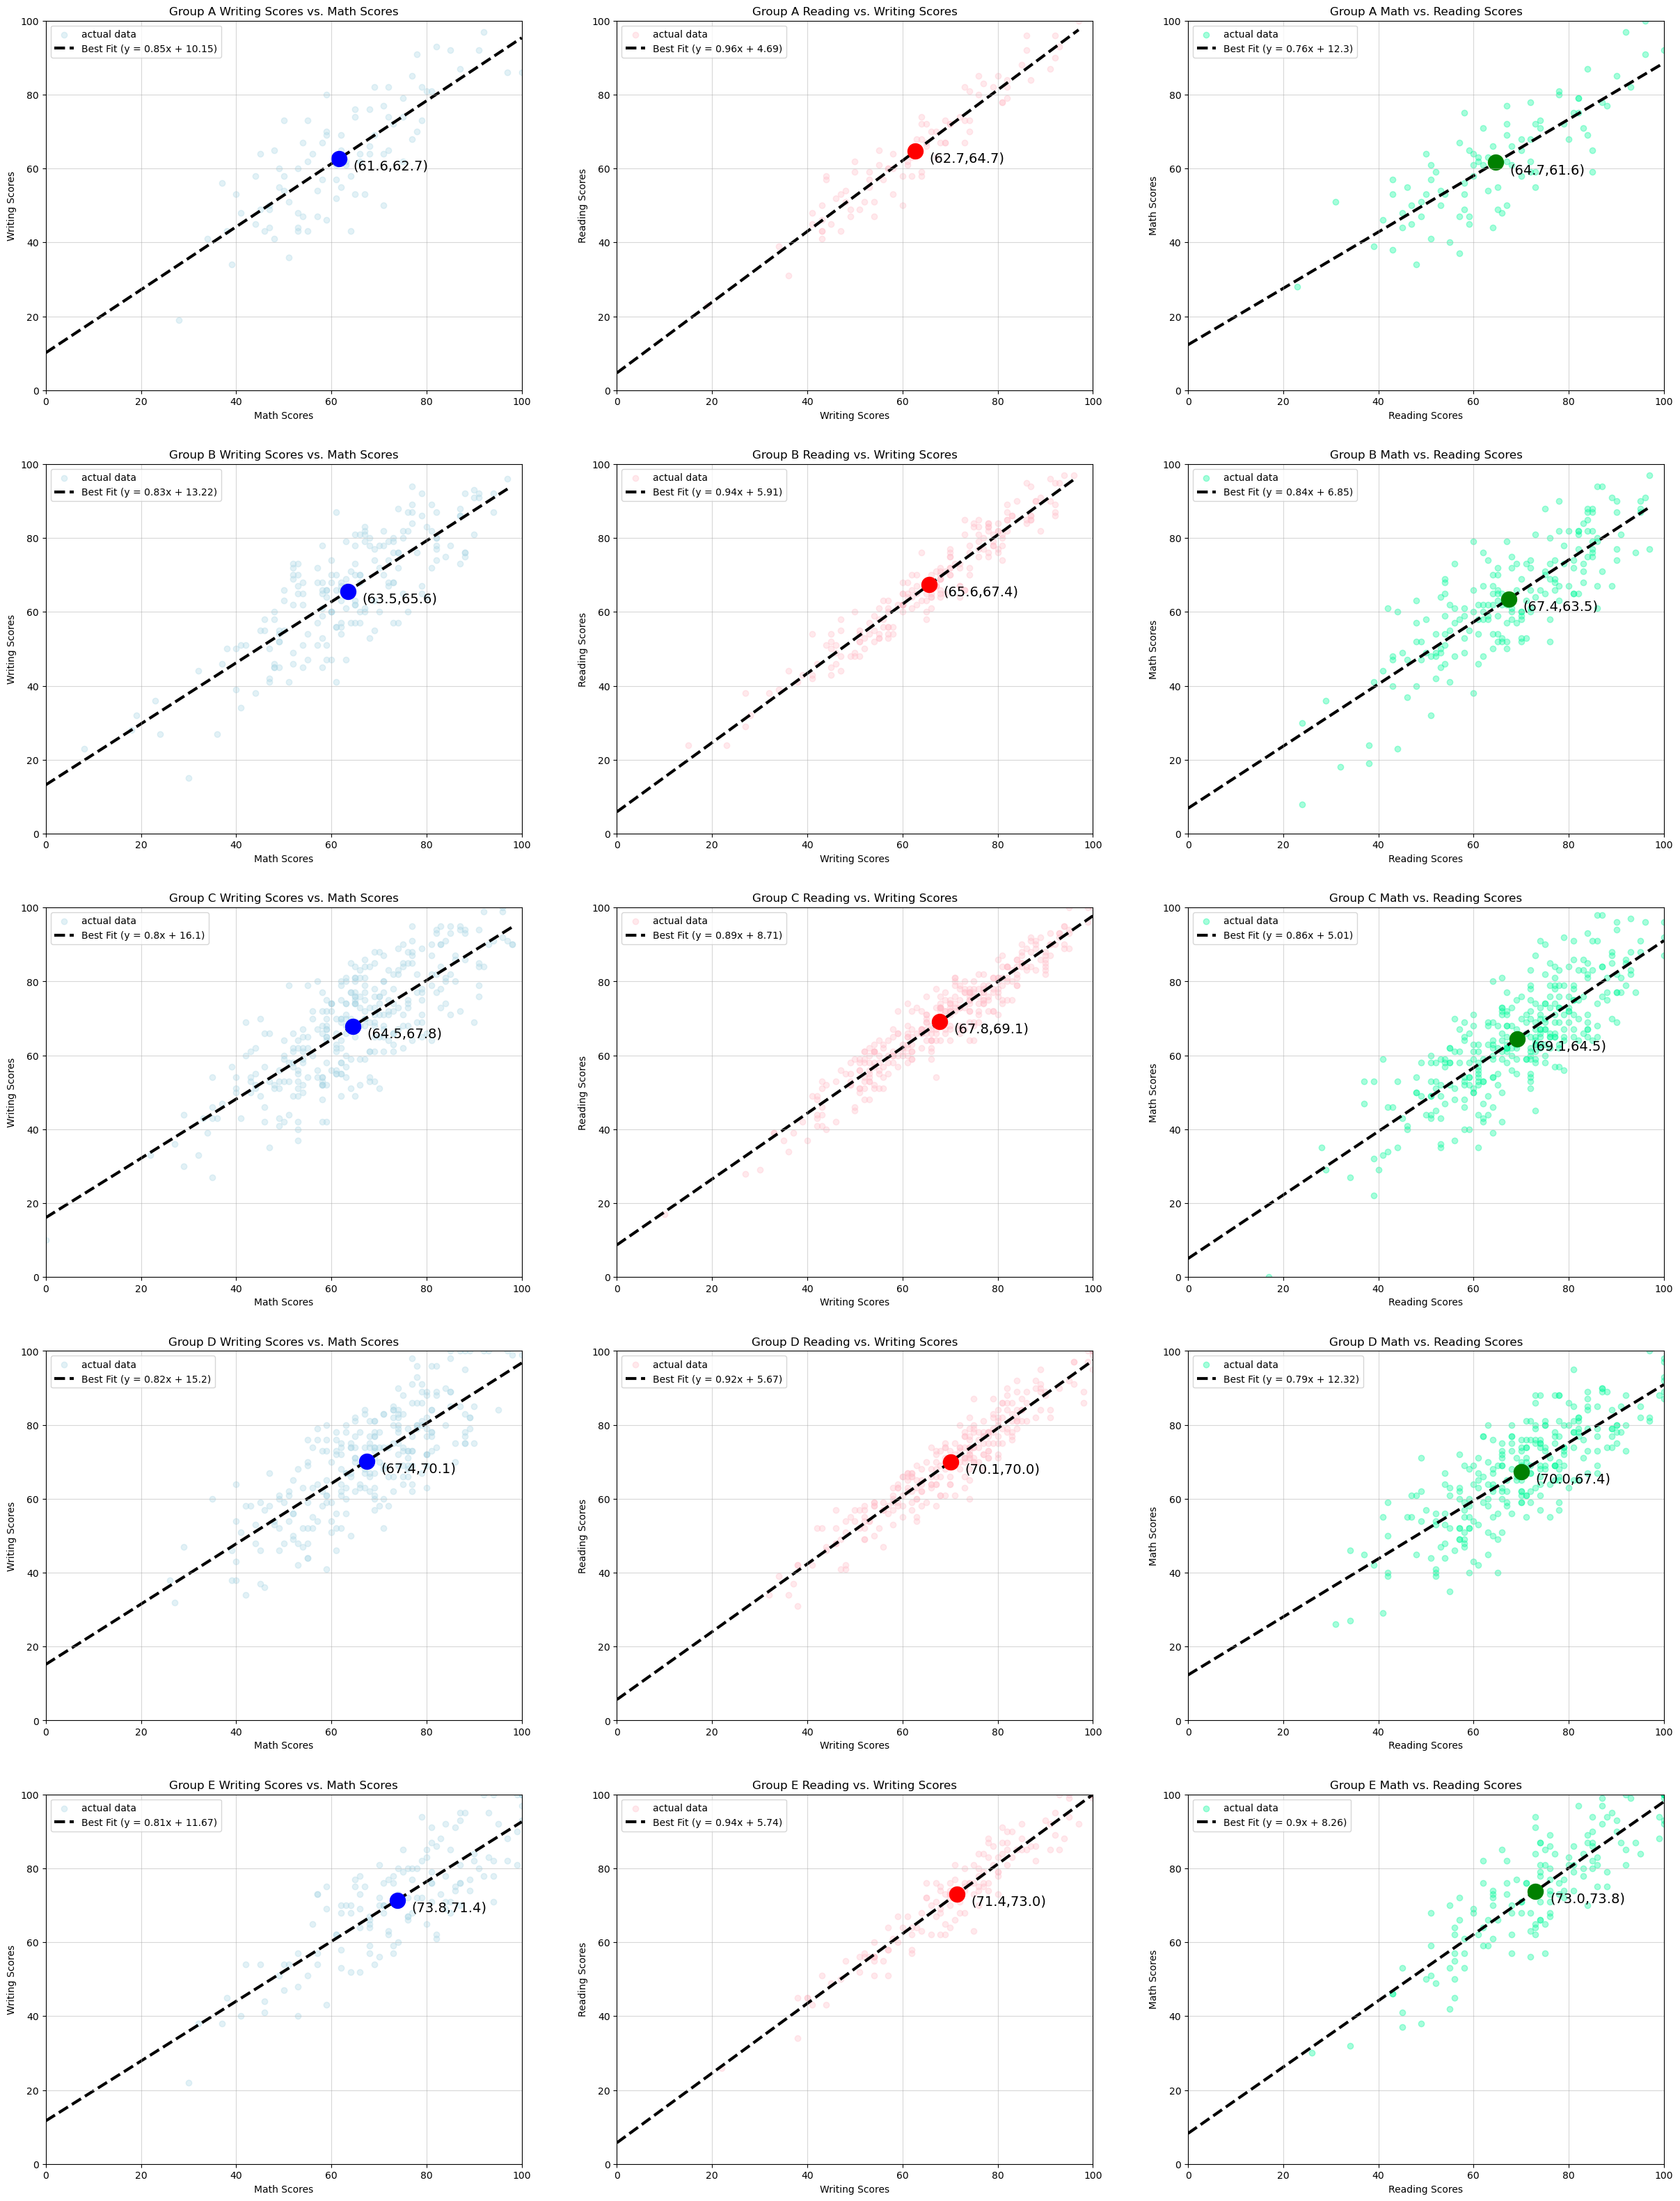

In [68]:
#initializng a 3x2 subplot figure for plotting the male and female regression lines
fig,axs = plt.subplots(nrows=5,ncols=3,figsize=(30,40))

#initializing a list of 3 sublists where each sublist contains the respective male and female x axis data for 
#each row of subplots
xs = [[groupA_math_scores,groupA_writing_scores,groupA_reading_scores],[groupB_math_scores,groupB_writing_scores,groupB_reading_scores],[groupC_math_scores,groupC_writing_scores,groupC_reading_scores],[groupD_math_scores,groupD_writing_scores,groupD_reading_scores],[groupE_math_scores,groupE_writing_scores,groupE_reading_scores]]

#initializing a list of 3 sublists where each sublist contains the respective male and female y axis data for 
#each row of the subplots
ys = [[groupA_writing_scores,groupA_reading_scores,groupA_math_scores],[groupB_writing_scores,groupB_reading_scores,groupB_math_scores],[groupC_writing_scores,groupC_reading_scores,groupC_math_scores],[groupD_writing_scores,groupD_reading_scores,groupD_math_scores],[groupE_writing_scores,groupE_reading_scores,groupE_math_scores]]

#initializing a list of 3 sublists where each sublist contians the respective male and female linear regression
#parameters for each row of the subplots 
para = [[groupA_math_writing_parameters,groupA_writing_reading_parameters,groupA_reading_math_parameters],[groupB_math_writing_parameters,groupB_writing_reading_parameters,groupB_reading_math_parameters],[groupC_math_writing_parameters,groupC_writing_reading_parameters,groupC_reading_math_parameters],[groupD_math_writing_parameters,groupD_writing_reading_parameters,groupD_reading_math_parameters],[groupE_math_writing_parameters,groupE_writing_reading_parameters,groupE_reading_math_parameters]]

#initializing a list of 3 sublists where each sublist contains the respective male and female subplot title
#for each row of the subplots
titles = [['Group A Writing Scores vs. Math Scores','Group A Reading vs. Writing Scores','Group A Math vs. Reading Scores'],['Group B Writing Scores vs. Math Scores','Group B Reading vs. Writing Scores','Group B Math vs. Reading Scores'],['Group C Writing Scores vs. Math Scores','Group C Reading vs. Writing Scores','Group C Math vs. Reading Scores'],['Group D Writing Scores vs. Math Scores','Group D Reading vs. Writing Scores','Group D Math vs. Reading Scores'],['Group E Writing Scores vs. Math Scores','Group E Reading vs. Writing Scores','Group E Math vs. Reading Scores']]

#initializng a list of 3 tuples where each tuples contains the axis labels for that row of subplots 
axs_labels = [('Math Scores','Writing Scores'),('Writing Scores','Reading Scores'),('Reading Scores','Math Scores')]

#initializing a list of 3 sublists where each sublist contains the respective male and female mean value scatter 
#color for each row of the subplots
colors = ['blue','red','green']

#initializing a list of 3 sublists where each sublist contains the respective male and female scatter point 
#color for each row of the subplots
scattercolors = ['lightblue','pink','mediumspringgreen']

#iterating over i = 0,1,2 where each i is a row of subplots
for i in range(5):
    
    #iterating over j = 0,1 where each j is a column of suplots 
    for j in range(3):
        
        #plotting the respective scatter plot for each of the 6 subplots using the already initialized lists
        axs[i,j].scatter(xs[i][j],ys[i][j],color=scattercolors[j],alpha=.35,label='actual data',zorder=-20)
        
        #plotting the respective linear regression line for each of the 6 subplots using the already
        #initialized lists
        axs[i,j].plot([0,max(xs[i][j])],[para[i][j][1],Linear(max(xs[i][j]),para[i][j][0],para[i][j][1])],color='black',
                      linewidth=3,linestyle='dashed',zorder=-10,label=f'Best Fit (y = {round(para[i][j][0],2)}x + {round(para[i][j][1],2)})')
        
        #plotting (x_mean, y_mean) for each of the 6 suplots using the already initialized lists 
        axs[i,j].scatter(np.mean(xs[i][j]),np.mean(ys[i][j]),marker='.',s=1000,color=colors[j],zorder=0)

        #adding an annotation including the values of the (x_mean,y_mean) coordinate for each of the 6 suplots
        axs[i,j].annotate(f'({round(np.mean(xs[i][j]),1)},{round(np.mean(ys[i][j]),1)})',xy=(np.mean(xs[i][j])+3,np.mean(ys[i][j])-3),fontsize=14)

        #setting the title of all 6 of the subplots using the titles list
        axs[i,j].set_title(titles[i][j])
            
        #setting the x axis label of all 6 of the subplots using the axs_labels list
        axs[i,j].set_xlabel(axs_labels[j][0]) 

        #setting the y axis label of all 6 of the subplots using the axs_labels list
        axs[i,j].set_ylabel(axs_labels[j][1]) 
           
        #setting a uniform x limit across all 6 of the subplots 
        axs[i,j].set_xlim(0,100)
    
        #setting a uniform y limit across all 6 of the subplots 
        axs[i,j].set_ylim(0,100)
    
        #initialzing a legend for each of the 6 subplots 
        axs[i,j].legend()
        
        #initializng a grid for each of the 6 subplots
        axs[i,j].grid(alpha=.5)


Here we see lines of best fit for each of the ethnic groups. While this may be a lot at once, looking down a column of plots, we see the mean x-y coordinate shifting up and to the right across all subjects. For a better look at the difference in ethnic groups, we can make a barplot. 

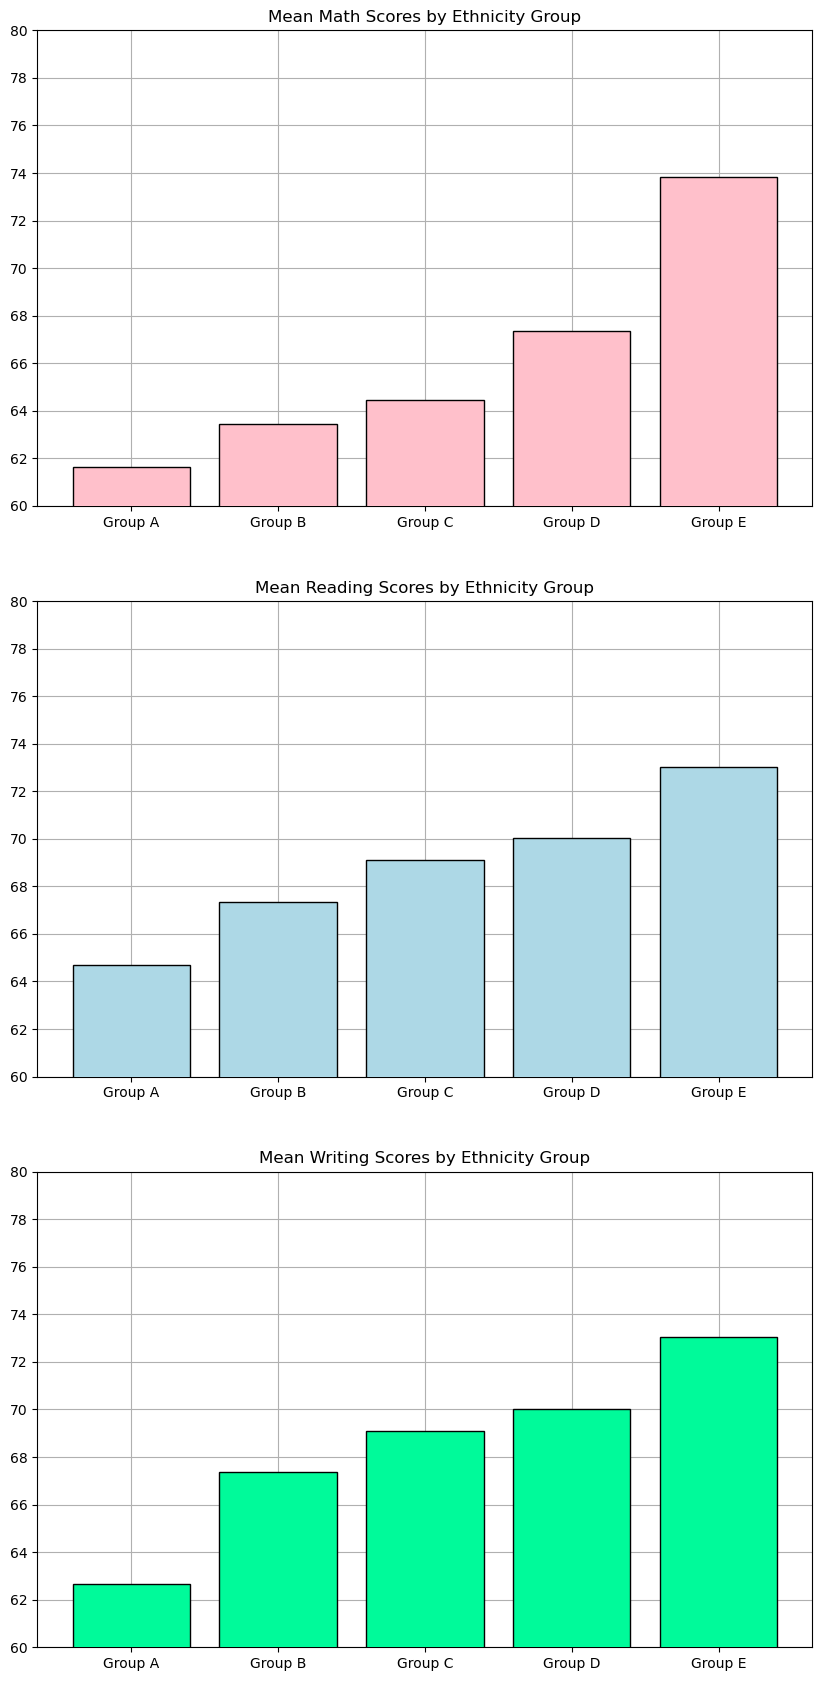

In [32]:
#creating a list that holds the mean score for each of the ethnicity groups for each of the subjects
math_heights = [np.mean(groupA_math_scores),np.mean(groupB_math_scores),np.mean(groupC_math_scores),np.mean(groupD_math_scores),np.mean(groupE_math_scores)]

reading_heights = [np.mean(groupA_reading_scores),np.mean(groupB_reading_scores),np.mean(groupC_reading_scores),np.mean(groupD_reading_scores),np.mean(groupE_reading_scores)]

writing_heights = [np.mean(groupA_writing_scores),np.mean(groupB_reading_scores),np.mean(groupC_reading_scores),np.mean(groupD_reading_scores),np.mean(groupE_reading_scores)]

#creating a list holding the titles for each of the subplots 
titles = ['Mean Math Scores by Ethnicity Group','Mean Reading Scores by Ethnicity Group','Mean Writing Scores by Ethnicity Group']

#initializng the plot figure
fig,axs = plt.subplots(nrows=3,ncols=1,figsize=(10,21))

#plottig the bar graphs on each of subplots
axs[0].bar(range(5),math_heights,color='pink',edgecolor='black',zorder=20)

axs[1].bar(range(5),reading_heights,color='lightblue',edgecolor='black',zorder=20)

axs[2].bar(range(5),writing_heights,color='mediumspringgreen',edgecolor='black',zorder=20)

#iterating over the axes
for i in range(3):
    
    #setting the title of each of the subplots 
    axs[i].set_title(titles[i])
    
    #setting the x ticks to show the ethnicity group
    axs[i].set_xticks(ticks=range(5),labels=['Group A','Group B','Group C','Group D','Group E'])
    
    #setting the y ticks
    axs[i].set_yticks(ticks=[i for i in range(60,82,2)])
    
    #setting the y limit
    axs[i].set_ylim(60,80)
    
    #plotting the grid
    axs[i].grid()

Above is an easy way of seeing the mean score of each subject for each group. When we think back to the p-value matrix, we can see why group A is significantly different than group E or why group B and C are insignificant.  When looking at the math plot in specific, groups A-C are very close to eachother while groups D and are different from eachother and from the other 3 groups. More or less, as the difference in group mean increases, it seems that the p-value decreases.

### Lunch Type Analysis

In [27]:
#creating mask for each of the lunch types
standard_mask = student_data['lunch'] == 'standard'

reduced_mask = student_data['lunch'] == 'free/reduced'

#creating the subsets using the masks
standard_data = student_data[standard_mask]

reduced_data = student_data[reduced_mask]

In [28]:
#getting correlation matrices for each of the lunch types in the dataset
standard_matrix = standard_data.corr(numeric_only=True)

reduced_matrix = reduced_data.corr(numeric_only=True)

#creating masks to only show the lower triangle of each matrix
standard_mask = np.triu(np.ones_like(standard_matrix, dtype=bool))

reduced_mask = np.triu(np.ones_like(reduced_matrix, dtype=bool))

Text(0.5, 1.0, 'Free/Reduced Lunch')

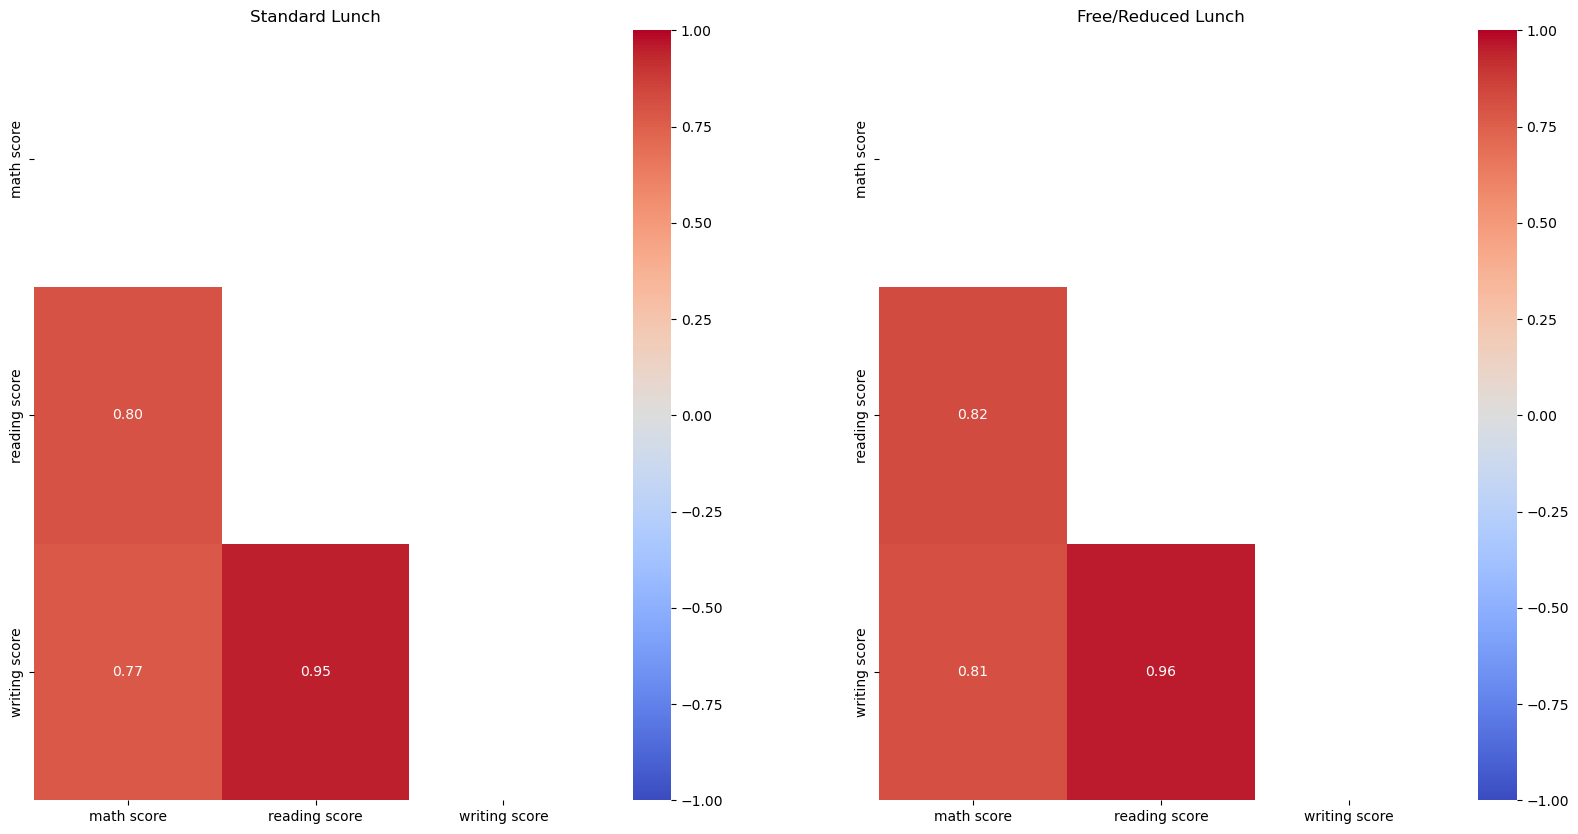

In [29]:
#initializing figure to plot the matrices
fig, axs = plt.subplots(ncols=2,figsize=(20, 10))

#plotting correlation matrix for each of the lunch types 
sns.heatmap(standard_matrix, annot=True, vmin = -1, vmax = 1, fmt=".2f", cmap='coolwarm', mask=standard_mask, ax=axs[0])

sns.heatmap(reduced_matrix, annot=True, vmin = -1, vmax = 1, fmt=".2f", cmap='coolwarm', mask=reduced_mask, ax=axs[1])

#setting the title of each of the subplots 
axs[0].set_title('Standard Lunch')

axs[1].set_title('Free/Reduced Lunch')

We see a correlation amtrix similar to the one we saw when we split up the ethnic groups. The reading/writing correlation stays at that .95-.96 value and the math relationships continue to show a lesser correlation 

/Users/trentonsmiley/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x1000 with 0 Axes>

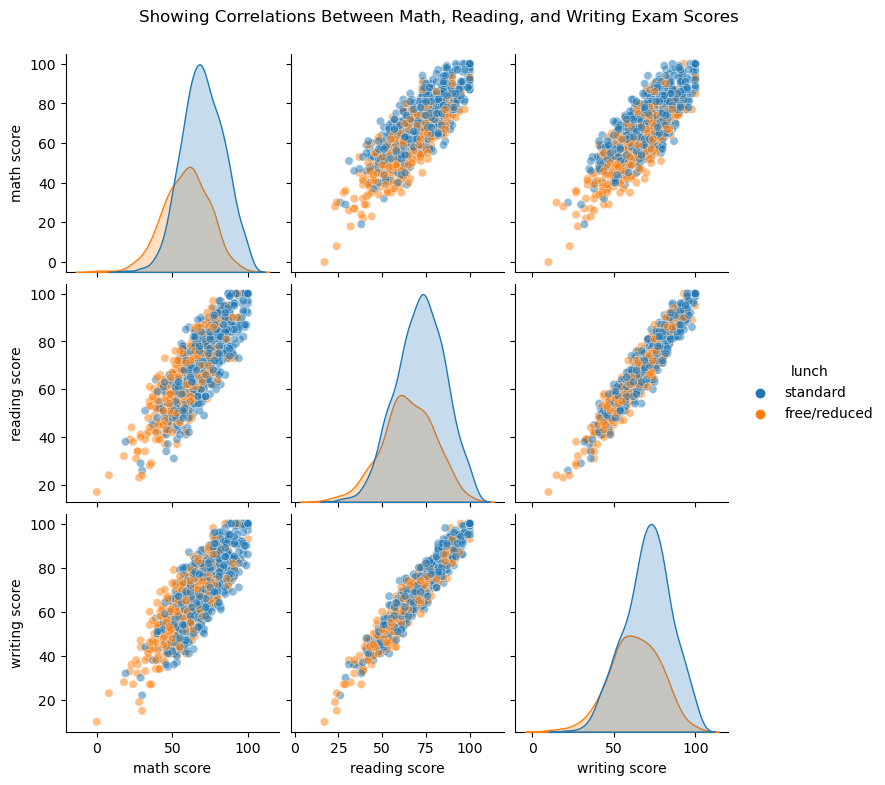

In [30]:
#recreating the numerical dataframe of the original student data
numerical_df = student_data.drop([i for i in student_data.columns if i not in ['math score','reading score','writing score','lunch']],axis=1)

#calling the figure constructer and setting figure size 
fig = plt.figure(figsize=(10,10))

#making a seaborn pairplot of the columns and calling parameters to customize it 
#this time we use the hue parameter to separate the data by lunch type
g = sns.pairplot(numerical_df,hue='lunch',diag_kind='kde',plot_kws={'color':'teal','alpha':0.5},diag_kws={'fill':True,'color':'teal'})

#setting the title of the figure
g.fig.suptitle('Showing Correlations Between Math, Reading, and Writing Exam Scores',y=1.04)

#saving the plot to files 
plt.savefig('Lunch Correlation.png')

From the pairplot above, it is hard to see if the lunch types have different testing success. However, we do see that there are a lot more standard lunch type students than there are reduced lunch type students. We will do further analysis to see how the lunch type of a student changes their academic success on tests.

In [32]:
#initialzing variables told hold standard and reduced lunch scores for each subject
standard_math_scores, standard_reading_scores, standard_writing_scores = standard_data['math score'], standard_data['reading score'], standard_data['writing score']

reduced_math_scores, reduced_reading_scores, reduced_writing_scores = reduced_data['math score'], reduced_data['reading score'], reduced_data['writing score']

#finding the linear parameters of the standard writing v. math regression line
standard_math_writing_parameters, _ = curve_fit(Linear,standard_math_scores,standard_writing_scores)

#finding the linear parameters of the standard math v. reading regression line  
standard_reading_math_parameters, _ = curve_fit(Linear,standard_reading_scores,standard_math_scores)

#finding the linear parameters of the standard reading v. writing regression line 
standard_writing_reading_parameters, _ = curve_fit(Linear,standard_writing_scores,standard_reading_scores)

#using the standard writing v. math parameters with the linear model to find the expected standard writing scores 
standard_expected_writing_scores = Linear(standard_math_scores,standard_math_writing_parameters[0],standard_math_writing_parameters[1])

#using the standard math v. reading parameters with the linear model to find the expected standard math scores 
standard_expected_math_scores = Linear(standard_reading_scores,standard_reading_math_parameters[0],standard_reading_math_parameters[1])

#using the standard reading v. writing parameters with the linear model to find the expected standard reading scores 
standard_expected_reading_scores = Linear(standard_writing_scores,standard_writing_reading_parameters[0],standard_writing_reading_parameters[1])

#finding the linear parameters of the reduced writing v. math regression line 
reduced_math_writing_parameters, _ = curve_fit(Linear,reduced_math_scores,reduced_writing_scores)

#finding the linear parameters of the reduced math v. reading regression line 
reduced_reading_math_parameters, _ = curve_fit(Linear,reduced_reading_scores,reduced_math_scores)

#finding the linear parameters of the reduced reading v. writing regression line 
reduced_writing_reading_parameters, _ = curve_fit(Linear,reduced_writing_scores,reduced_reading_scores)

#using the reduced writing v. math parameters with the linear model to find the expected reduced writing scores 
reduced_expected_writing_scores = Linear(reduced_math_scores,reduced_math_writing_parameters[0],reduced_math_writing_parameters[1])

#using the reduced math v. reading parameters with the linear model to find the expected reduced math scores
reduced_expected_math_scores = Linear(reduced_reading_scores,reduced_reading_math_parameters[0],reduced_reading_math_parameters[1])

#using the reduced reading v. writing parameters with the linear model to find the expected reduced reading scores
reduced_expected_reading_scores = Linear(reduced_writing_scores,reduced_writing_reading_parameters[0],reduced_writing_reading_parameters[1])


Text(0.5, 0.94, 'Test Score Correlation Differences Between Lunch Types')

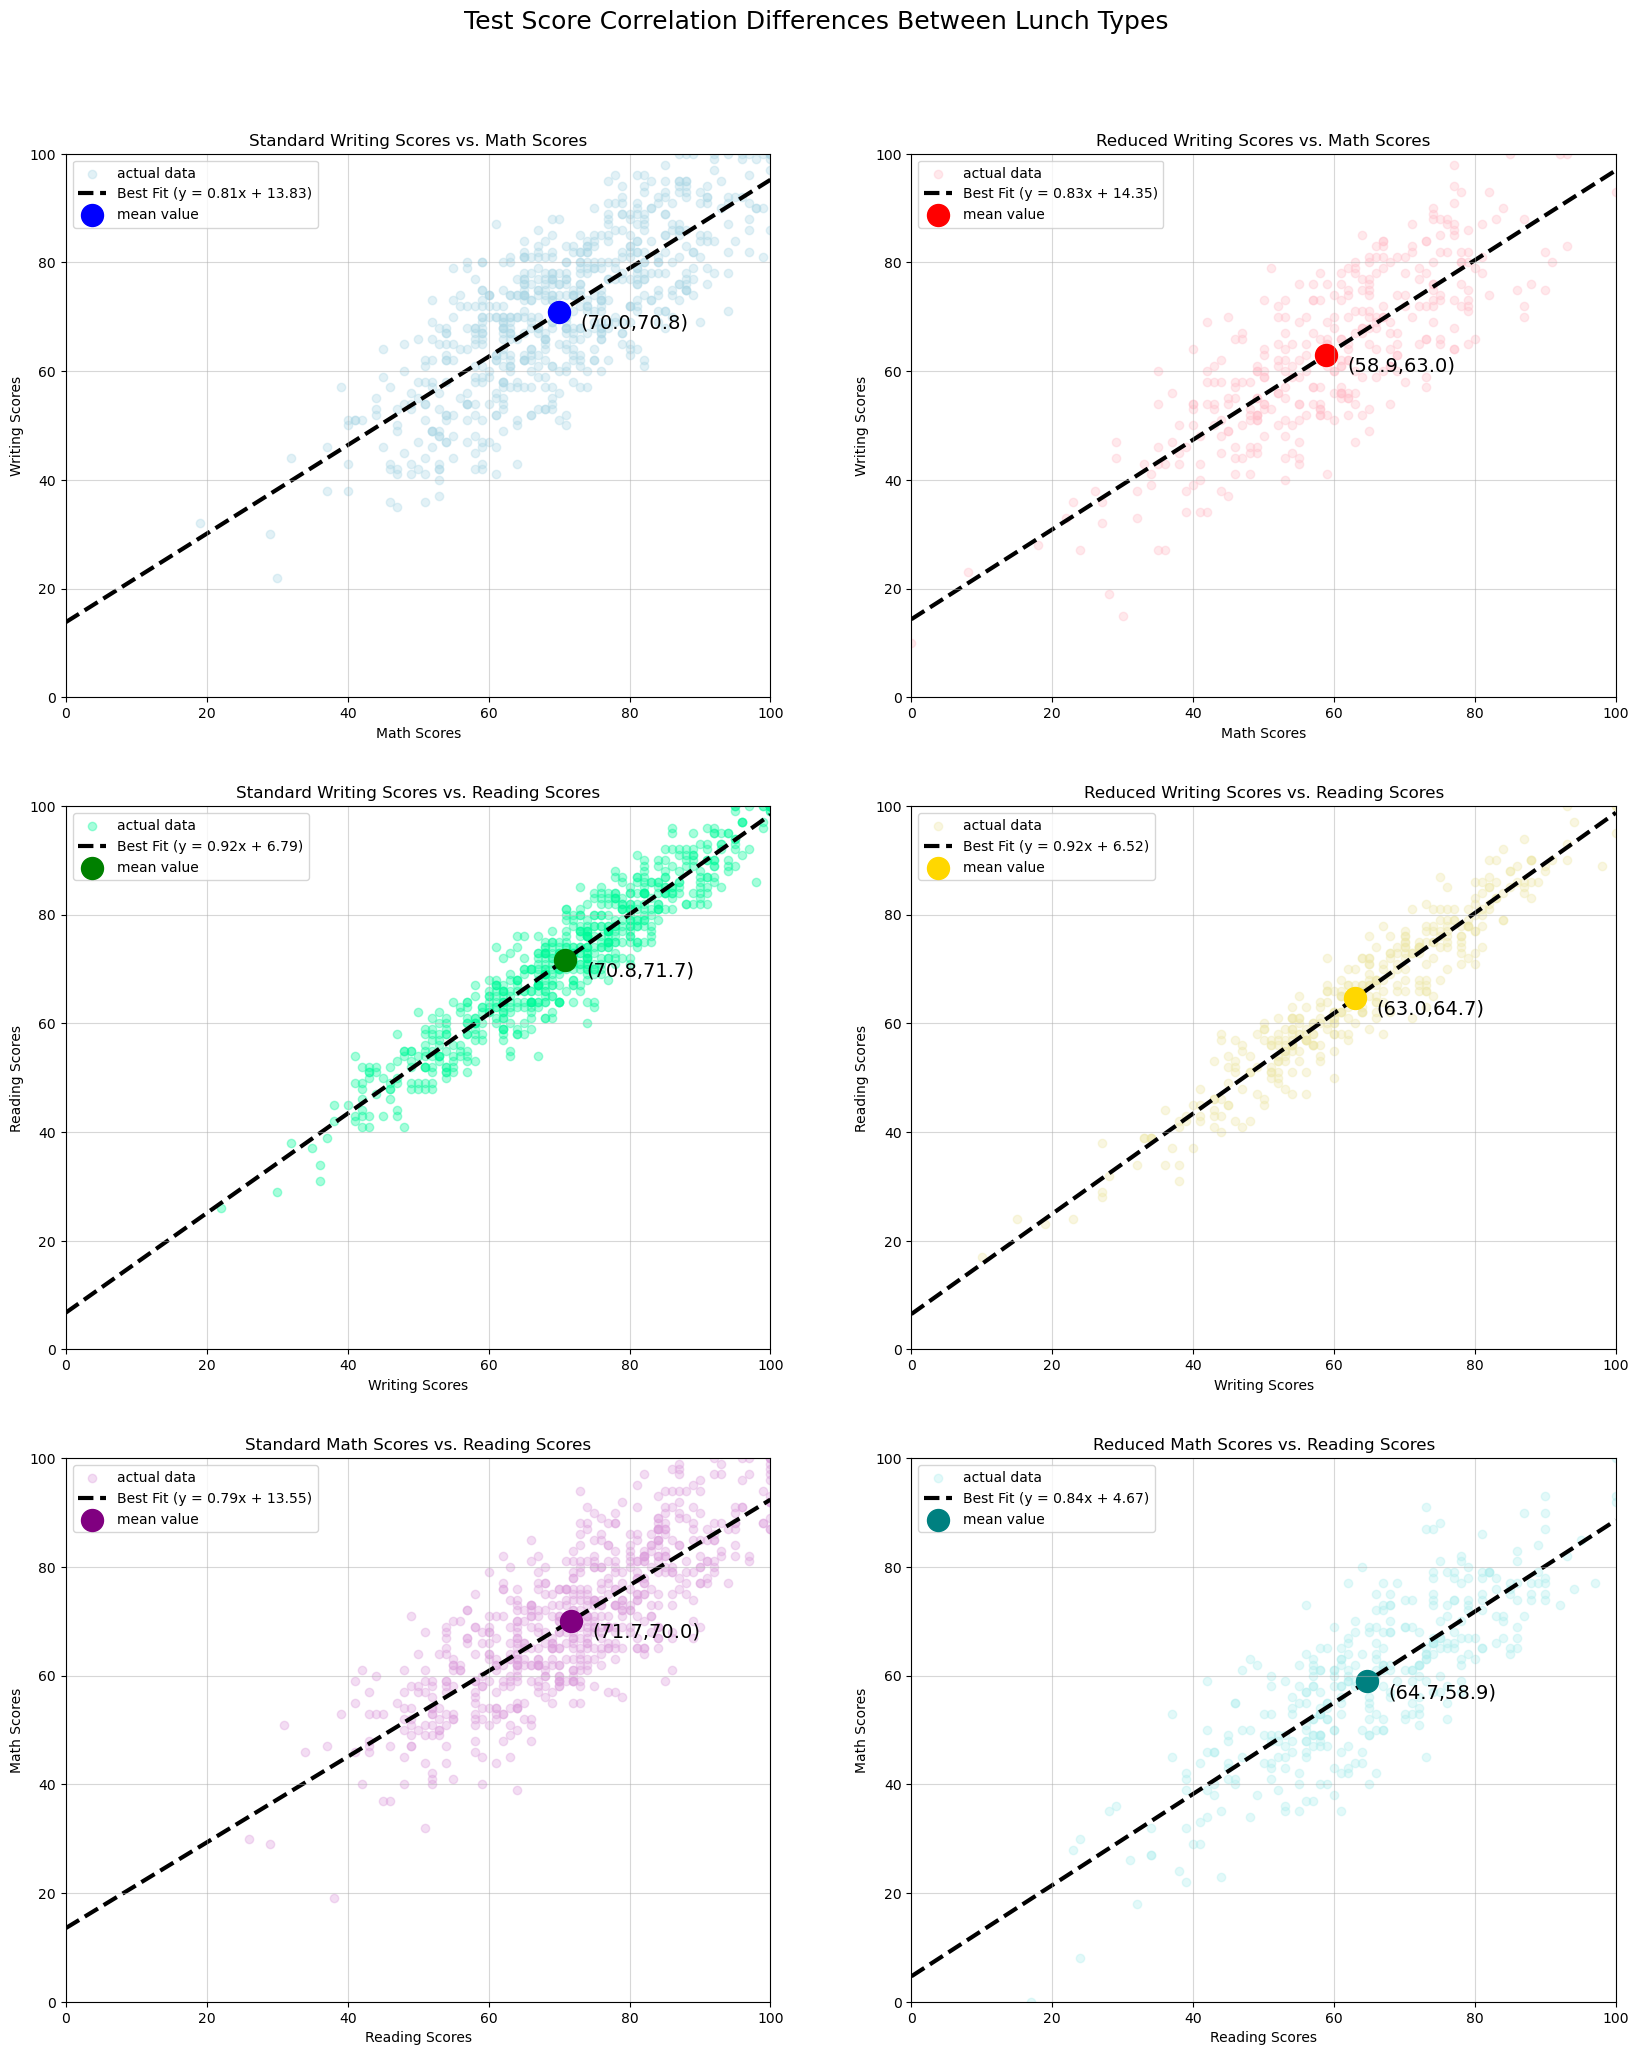

In [33]:
#initializing figure to plot
fig, axs = plt.subplots(ncols=2,nrows=3,figsize=(20, 24))

#initializing a list of 3 sublists where each sublist contains the respective standard and reduced x axis data for 
#each row of subplots
xs = [[standard_math_scores,reduced_math_scores],[standard_writing_scores,reduced_writing_scores],[standard_reading_scores,reduced_reading_scores]]

#initializing a list of 3 sublists where each sublist contains the respective standard and reduced y axis data for 
#each row of the subplots
ys = [[standard_writing_scores,reduced_writing_scores],[standard_reading_scores,reduced_reading_scores],[standard_math_scores,reduced_math_scores]]

#initializing a list of 3 sublists where each sublist contians the respective standard and reduced linear regression
#parameters for each row of the subplots 
para = [[standard_math_writing_parameters,reduced_math_writing_parameters],[standard_writing_reading_parameters,reduced_writing_reading_parameters],[standard_reading_math_parameters,reduced_reading_math_parameters]]

#initializing a list of 3 sublists where each sublist contains the respective standard and reduced subplot title
#for each row of the subplots
titles = [['Standard Writing Scores vs. Math Scores','Reduced Writing Scores vs. Math Scores'],['Standard Writing Scores vs. Reading Scores','Reduced Writing Scores vs. Reading Scores'],['Standard Math Scores vs. Reading Scores','Reduced Math Scores vs. Reading Scores']]

#initializng a list of 3 tuples where each tuples contains the axis labels for that row of subplots 
axs_labels = [('Math Scores','Writing Scores'),('Writing Scores','Reading Scores'),('Reading Scores','Math Scores')]

#initializing a list of 3 sublists where each sublist contains the respective standard and reduced mean value scatter 
#color for each row of the subplots
colors = [['blue','red'],['green','gold'],['purple','teal']]

#initializing a list of 3 sublists where each sublist contains the respective standard and reduced scatter point 
#color for each row of the subplots
scattercolors = [['lightblue','pink'],['mediumspringgreen','palegoldenrod'],['plum','paleturquoise']]

#iterating over i = 0,1,2 where each i is a row of subplots
for i in range(3):
    
    #iterating over j = 0,1 where each j is a column of suplots 
    for j in range(2):
        
        #plotting the respective scatter plot for each of the 6 subplots using the already initialized lists
        axs[i,j].scatter(xs[i][j],ys[i][j],color=scattercolors[i][j],alpha=.35,label='actual data',zorder=-20)
        
        #plotting the respective linear regression line for each of the 6 subplots using the already
        #initialized lists
        axs[i,j].plot([0,max(xs[i][j])],[para[i][j][1],Linear(max(xs[i][j]),para[i][j][0],para[i][j][1])],color='black',
                      linewidth=3,linestyle='dashed',zorder=-10,label=f'Best Fit (y = {round(para[i][j][0],2)}x + {round(para[i][j][1],2)})')
        
        #plotting (x_mean, y_mean) for each of the 6 suplots using the already initialized lists 
        axs[i,j].scatter(np.mean(xs[i][j]),np.mean(ys[i][j]),marker='.',s=1000,color=colors[i][j],zorder=0,label='mean value')

        #adding an annotation including the values of the (x_mean,y_mean) coordinate for each of the 6 suplots
        axs[i,j].annotate(f'({round(np.mean(xs[i][j]),1)},{round(np.mean(ys[i][j]),1)})',xy=(np.mean(xs[i][j])+3,np.mean(ys[i][j])-3),fontsize=14)

        #setting the title of all 6 of the subplots using the titles list
        axs[i,j].set_title(titles[i][j])
            
        #setting the x axis label of all 6 of the subplots using the axs_labels list
        axs[i,j].set_xlabel(axs_labels[i][0]) 

        #setting the y axis label of all 6 of the subplots using the axs_labels list
        axs[i,j].set_ylabel(axs_labels[i][1]) 
           
        #setting a uniform x limit across all 6 of the subplots 
        axs[i,j].set_xlim(0,100)
    
        #setting a uniform y limit across all 6 of the subplots 
        axs[i,j].set_ylim(0,100)
    
        #initialzing a legend for each of the 6 subplots 
        axs[i,j].legend()
        
        #initializng a grid for each of the 6 subplots
        axs[i,j].grid(alpha=.5)

#setting the figure super title 
fig.suptitle('Test Score Correlation Differences Between Lunch Types',y=.94,fontsize=18)


Using our lines of best fit for each of the subjects, we can see that the mean test score for standard lunch students is higher than of reduced lunch students across all subjects.  While this gives us some surface insight into the influence of lunch type on test success, we will conduct the z and t test to provide evidence for a different in populations. 

In [34]:
#initializing variables for the number of students that belong to each of the lunch types  
n_standard, n_reduced, = len(standard_data), len(reduced_data) 

#initializing variables that hold the respective subject mean scores for each of the lunch types  
standard_math_mean, standard_reading_mean, standard_writing_mean = np.mean(standard_math_scores), np.mean(standard_reading_scores), np.mean(standard_writing_scores)

reduced_math_mean, reduced_reading_mean, reduced_writing_mean = np.mean(reduced_math_scores), np.mean(reduced_reading_scores), np.mean(reduced_writing_scores)

#initializing variables that hold the respective subject standard deviation of scores for each of the lunch types 
standard_math_std, standard_reading_std, standard_writing_std = np.std(standard_math_scores), np.std(standard_reading_scores), np.std(standard_writing_scores)

reduced_math_std, reduced_reading_std, reduced_writing_std = np.std(reduced_math_scores), np.std(reduced_reading_scores), np.std(reduced_writing_scores)

#performing the 2-sample Z-test for each of the subjects
math_z, math_p = twoSampZ(standard_math_mean,reduced_math_mean,0,standard_math_std,reduced_math_std,n_standard,n_reduced)

reading_z, reading_p = twoSampZ(standard_reading_mean,reduced_reading_mean,0,standard_reading_std,reduced_reading_std,n_standard,n_reduced)

writing_z, writing_p = twoSampZ(standard_writing_mean,reduced_writing_mean,0,standard_writing_std,reduced_writing_std,n_standard,n_reduced)

#displaying the results
print('Math:\n')

print(f'The z-score and p-value for the 2-sample Z-test between reduced and standard lunch groups is {math_z:.2f} and {math_p:.3g}.\n')

print('Reading:\n')

print(f'The z-score and p-value for the 2-sample Z-test between reduced and standard lunch groups is {reading_z:.2f} and {reading_p:.3g}.\n')

print('Writing:\n')

print(f'The z-score and p-value for the 2-sample Z-test between reduced and standard lunch groups is {writing_z:.2f} and {writing_p:.3g}.\n')


Math:

The z-score and p-value for the 2-sample Z-test between reduced and standard lunch groups is 11.50 and 1.35e-30.

Reading:

The z-score and p-value for the 2-sample Z-test between reduced and standard lunch groups is 7.30 and 2.85e-13.

Writing:

The z-score and p-value for the 2-sample Z-test between reduced and standard lunch groups is 7.85 and 4.15e-15.



The z-test reinforces the findings from the best fit line plots. With p-value virtually zero for every subject, it is reasonable to conclude that the standard and reduced lunch groups are significantly different in terms of mean test score implying that lunch type is a factor in student success.

In [35]:
#performing the 2-sample independent t-test and unpacking the result for each of the subjects
math_ttest = ttest(standard_math_scores, reduced_math_scores, equal_var = False)

math_t, math_tp, math_conf_interval = math_ttest.statistic, math_ttest.pvalue, math_ttest.confidence_interval(confidence_level=.9)

reading_ttest = ttest(standard_reading_scores, reduced_reading_scores, equal_var = False)  

reading_t, reading_tp, reading_conf_interval = reading_ttest.statistic, reading_ttest.pvalue, reading_ttest.confidence_interval(confidence_level=.9)

writing_ttest = ttest(standard_writing_scores, reduced_writing_scores, equal_var = False)  

writing_t, writing_tp, writing_conf_interval = writing_ttest.statistic, writing_ttest.pvalue, writing_ttest.confidence_interval(confidence_level=.9)

#displaying the results
print('Standard vs. Reduced Lunch T-Test\n')

print('Math')

print(f't-statistic, p-value: {round(math_t,2)} & {math_tp:.3g}\n90% confidence interval:({math_conf_interval.low:.2f},{math_conf_interval.high:.2f})\n')

print('Reading')

print(f't-statistic, p-value: {round(reading_t,2)} & {reading_tp:.3g}\n90% confidence interval: ({reading_conf_interval.low:.2f},{reading_conf_interval.high:.2f})\n')

print('Writing')

print(f't-statistic, p-value: {round(writing_t,2)} & {writing_tp:.3g}\n90% confidence interval: ({writing_conf_interval.low:.2f},{writing_conf_interval.high:.2f})\n')


Standard vs. Reduced Lunch T-Test

Math
t-statistic, p-value: 11.48 & 5.54e-28
90% confidence interval:(9.52,12.71)

Reading
t-statistic, p-value: 7.29 & 8.42e-13
90% confidence interval: (5.42,8.58)

Writing
t-statistic, p-value: 7.84 & 1.72e-14
90% confidence interval: (6.16,9.44)



By running the t-test, we confirm that the p-values are correct and we also see by obtaining the confidence interval that 0, meaning equality in population mean, is not included within the interval giving us another piece of evidence to support our findings.

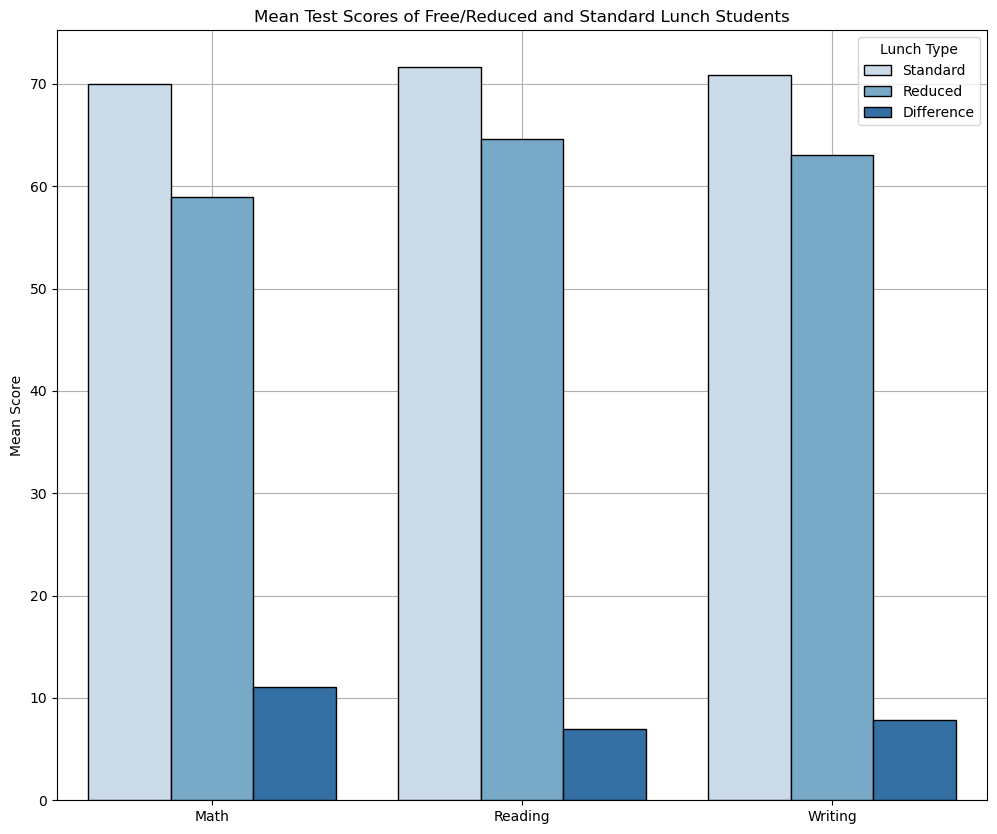

In [37]:
#creating a dataframe holding the mean score of each lunch type and the difference between them for each subject
mean_score_df = pd.DataFrame(
    
    {
     
    'Subject' : ['Math','Math','Math','Reading','Reading','Reading','Writing','Writing','Writing'],
    
    'Lunch Type': ['Standard','Reduced','Difference','Standard','Reduced','Difference','Standard','Reduced','Difference'],
    
    'Mean Score': [standard_math_mean,reduced_math_mean,standard_math_mean - reduced_math_mean,standard_reading_mean,reduced_reading_mean,standard_reading_mean - reduced_reading_mean,standard_writing_mean,reduced_writing_mean,standard_writing_mean - reduced_writing_mean]
    
    }
    
)

#intizializing figure for plotting
fig, axs = plt.subplots(figsize=(12,10))

#plotting a bar chart using the data from the dataframe
g = sns.barplot(data=mean_score_df,x='Subject',y='Mean Score',hue='Lunch Type',ax=axs,palette='Blues',edgecolor='black',zorder=20)

#removing x-axis label and setting title of the plot
axs.set(xlabel=None,title='Mean Test Scores of Free/Reduced and Standard Lunch Students')

#plotting the grid
axs.grid()

In the barplot above, the true difference in mean test scores across subjects is shown in more simplicity. Comparing the difference bar heights to our confidence intervals, we can see that the bar heights are within each of their respective intervals. 

### Education Level Analysis 

In [38]:
#getting all listed parental levles of education within the dataset
education_lvls = list(student_data['parental level of education'].unique())

#sorting them alphabetically
education_lvls.sort()

#creating masks for each one of the levels of education
masks = [student_data['parental level of education']==i for i in education_lvls]

#initialzing variables that will hold the subsets
associates_data = 0

bachelors_data = 0 

highschool_data = 0

masters_data = 0 

somecollege_data = 0 

somehs_data = 0

#bunching the variables into one list
datasets = [associates_data,bachelors_data,highschool_data,masters_data,somecollege_data,somehs_data]

#setting each variable in the list each to its corresponding subset
for i in range(len(masks)):
    
    datasets[i] = student_data[masks[i]]

#unpack the list back into the initialized variables 
associates_data, bachelors_data, highschool_data, masters_data, somecollege_data, somehs_data = datasets 

In [39]:
#initializing variables that hold the respective subject scores for each of the levels of education  
associates_math_scores, associates_reading_scores, associates_writing_scores = np.array(associates_data['math score']), np.array(associates_data['reading score']), np.array(associates_data['writing score'])

bachelors_math_scores, bachelors_reading_scores, bachelors_writing_scores = np.array(bachelors_data['math score']), np.array(bachelors_data['reading score']), np.array(bachelors_data['writing score'])

masters_math_scores, masters_reading_scores, masters_writing_scores = np.array(masters_data['math score']), np.array(masters_data['reading score']), np.array(masters_data['writing score'])

highschool_math_scores, highschool_reading_scores, highschool_writing_scores = np.array(highschool_data['math score']), np.array(highschool_data['reading score']), np.array(highschool_data['writing score'])

somecollege_math_scores, somecollege_reading_scores, somecollege_writing_scores = np.array(somecollege_data['math score']), np.array(somecollege_data['reading score']), np.array(somecollege_data['writing score'])

somehs_math_scores, somehs_reading_scores, somehs_writing_scores = np.array(somehs_data['math score']), np.array(somehs_data['reading score']), np.array(somehs_data['writing score'])

#initializing variables for the number of students that belong to each of the levels of education 
n_associates, n_bachelors, n_masters, n_highschool, n_somecollege, n_somehs = len(associates_data), len(bachelors_data), len(masters_data), len(highschool_data), len(somecollege_data), len(somehs_data) 

#initializing variables that hold the respective subject mean scores for each of the levels of education 
associates_math_mean, associates_reading_mean, associates_writing_mean = np.mean(associates_math_scores), np.mean(associates_reading_scores), np.mean(associates_writing_scores)

bachelors_math_mean, bachelors_reading_mean, bachelors_writing_mean = np.mean(bachelors_math_scores), np.mean(bachelors_reading_scores), np.mean(bachelors_writing_scores)

masters_math_mean, masters_reading_mean, masters_writing_mean = np.mean(masters_math_scores), np.mean(masters_reading_scores), np.mean(masters_writing_scores)

highschool_math_mean, highschool_reading_mean, highschool_writing_mean = np.mean(highschool_math_scores), np.mean(highschool_reading_scores), np.mean(highschool_writing_scores)

somecollege_math_mean, somecollege_reading_mean, somecollege_writing_mean = np.mean(somecollege_math_scores), np.mean(somecollege_reading_scores), np.mean(somecollege_writing_scores)

somehs_math_mean, somehs_reading_mean, somehs_writing_mean = np.mean(somehs_math_scores), np.mean(somehs_reading_scores), np.mean(somehs_writing_scores)

#initializing variables that hold the respective subject standard deviation of scores for each of the levels of education
associates_math_std, associates_reading_std, associates_writing_std = np.std(associates_math_scores), np.std(associates_reading_scores), np.std(associates_writing_scores)

bachelors_math_std, bachelors_reading_std, bachelors_writing_std = np.std(bachelors_math_scores), np.std(bachelors_reading_scores), np.std(bachelors_writing_scores)

masters_math_std, masters_reading_std, masters_writing_std = np.std(masters_math_scores), np.std(masters_reading_scores), np.std(masters_writing_scores)

highschool_math_std, highschool_reading_std, highschool_writing_std = np.std(highschool_math_scores), np.std(highschool_reading_scores), np.std(highschool_writing_scores)

somecollege_math_std, somecollege_reading_std, somecollege_writing_std = np.std(somecollege_math_scores), np.std(somecollege_reading_scores), np.std(somecollege_writing_scores)

somehs_math_std, somehs_reading_std, somehs_writing_std = np.std(somehs_math_scores), np.std(somehs_reading_scores), np.std(somehs_writing_scores)


In [41]:
#creating bunch tuples containing that contain the mean,standard deviation, and number of students for each of the levels of education for each of the 3 subjects
math_scores = [(associates_math_mean,associates_math_std,n_associates),(bachelors_math_mean,bachelors_math_std,n_bachelors),(masters_math_mean,masters_math_std,n_masters),(highschool_math_mean,highschool_math_std,n_highschool),(somecollege_math_mean,somecollege_math_std,n_somecollege),(somehs_math_mean,somehs_math_std,n_somehs)]

reading_scores = [(associates_reading_mean,associates_reading_std,n_associates),(bachelors_reading_mean,bachelors_reading_std,n_bachelors),(masters_reading_mean,masters_reading_std,n_masters),(highschool_reading_mean,highschool_reading_std,n_highschool),(somecollege_reading_mean,somecollege_reading_std,n_somecollege),(somehs_reading_mean,somehs_reading_std,n_somehs)]

writing_scores = [(associates_writing_mean,associates_writing_std,n_associates),(bachelors_writing_mean,bachelors_writing_std,n_bachelors),(masters_writing_mean,masters_writing_std,n_masters),(highschool_writing_mean,highschool_writing_std,n_highschool),(somecollege_writing_mean,somecollege_writing_std,n_somecollege),(somehs_writing_mean,somehs_writing_std,n_somehs)]

#creating a list that contains all 3 subjects of bunch tuples 
scores = [math_scores,reading_scores,writing_scores]

#creating a list of subject strings 
subjects = ['Math','Reading','Writing']

#creating a list of the different levels of education
groups = ['associates','bachelors','masters','highschool','somecollege','somehs']

#initializing empty list to be filled with p-value matrix for each of the subjects
scores_matrices = []

#iterating over the different subject score lists 
for i in scores:
    
    #initializing a variable for the average z-score and p-value 
    average_z = 0

    average_p = 0 
    
    #initializing an all zero 2d numpy array of shape 6x6
    matrix = np.zeros((6,6))
    
    #iterating over the different group tuples (associates - somecollege)
    for j in range(len(i)):
        
        #iterating over the other groups to perform all possible z-test permutations without repeating
        for k in range(j+1,len(i)):
            
            #performing the 2-sample Z-test 
            z, p = twoSampZ(i[j][0],i[k][0],0,i[j][1],i[k][1],i[j][2],i[k][2])
            
            #updating the value of the average values of z and p 
            average_z += abs(z)

            average_p += abs(p)
            
            #setting the corresponding indices in the matrix equal to the p-value
            matrix[j,k] = p; matrix[k,j] = p
            
        #setting the diagonal of the matrix equal to 1 because it is a z-test between identical samples
        matrix[j,j] = 1
    
    #appending the p-value matrix to the list of matrices 
    scores_matrices.append(matrix)


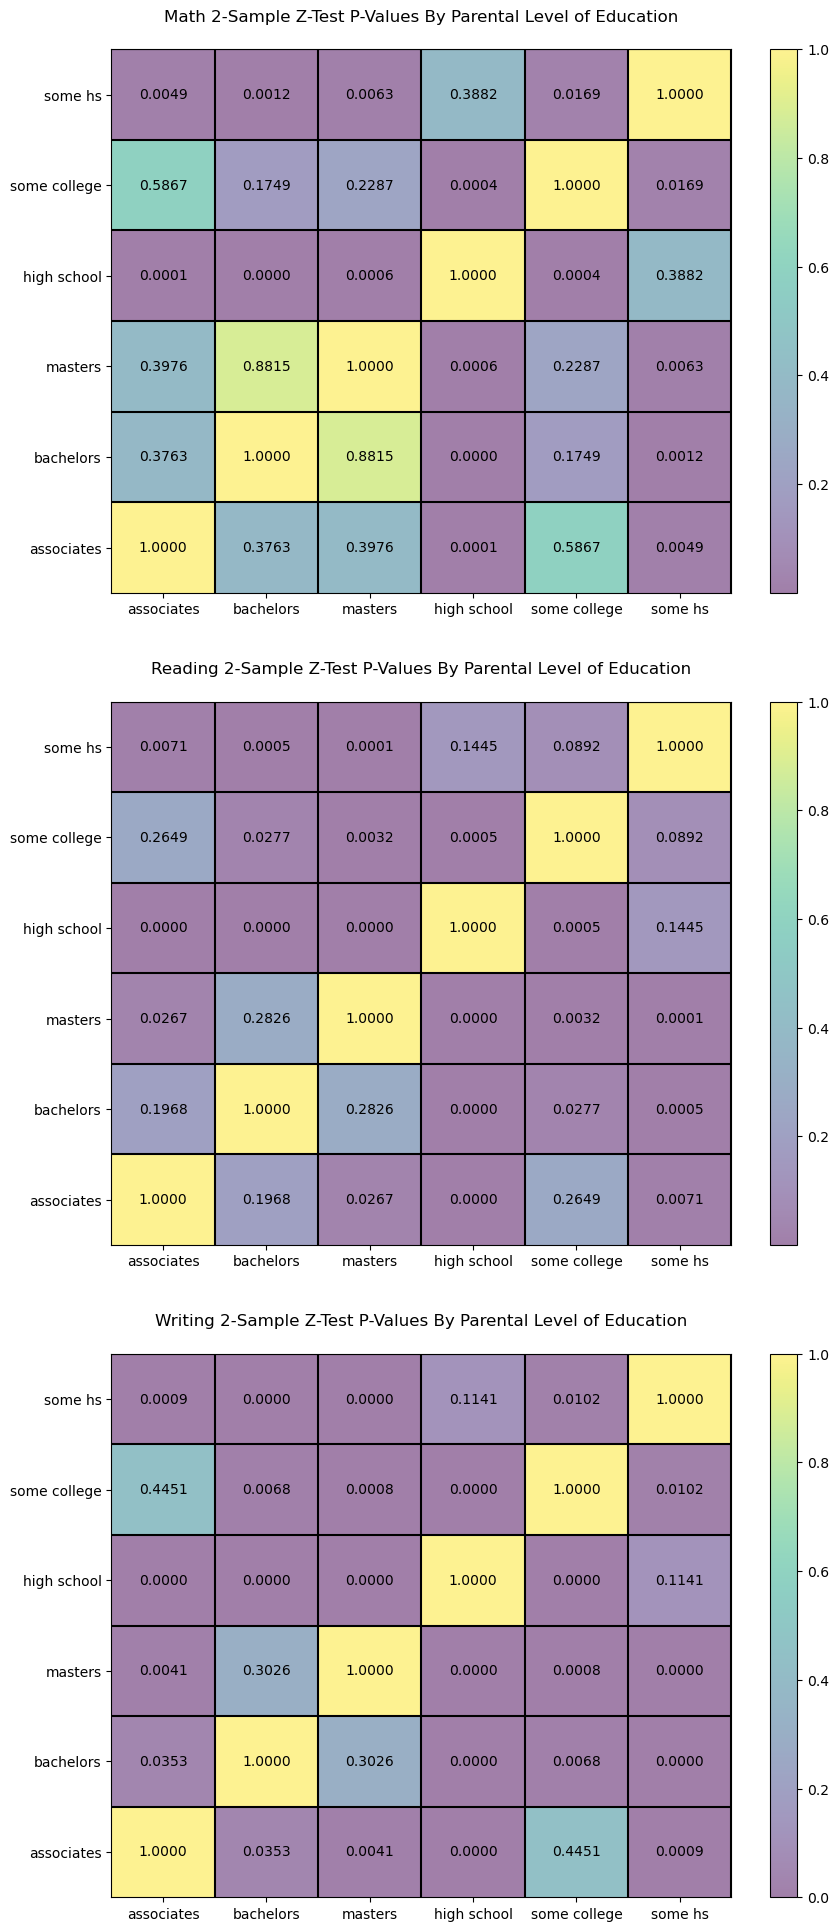

In [42]:
#creating a list of a the subjects  
subjects = ['Math','Reading','Writing']

#initializing the plotting figure 
fig, axs = plt.subplots(nrows=3,figsize=(10,24))

#iterating over the matrices
for i in range(3):
    
    #plotting a colormesh grid of the selected matrix 
    grid = axs[i].pcolormesh(scores_matrices[i],alpha=.5)

    #plotting a colorbar
    plt.colorbar(grid, ax=axs[i])

    #setting the x and y ticks to show what groups are being compared at each tile 
    axs[i].set_xticks(ticks=np.arange(.5,6,1),labels=['associates','bachelors','masters','high school','some college','some hs'])

    axs[i].set_yticks(ticks=np.arange(.5,6,1),labels=['associates','bachelors','masters','high school','some college','some hs'])

    #iterating over the x and y values in the grid
    for j in range(1,7):

        #using the vertical line and horizontal line functions to plot grid lines separating the tiles 
        axs[i].axhline(j,color='black')

        axs[i].axvline(j,color='black')
    
    #iterating over the y values corresponding the to number of rows in the matrix
    for y in range(scores_matrices[i].shape[0]):

        #iterating over the x values corresponding the to number of columns in the matrix
        for x in range(scores_matrices[i].shape[1]):

            #annotating the matrix to show the p-value on each tile
            axs[i].text(x + 0.5, y + 0.5, '%.4f' % scores_matrices[i][y, x], horizontalalignment='center', verticalalignment='center')
    
    #setting the title of each of the subplots 
    axs[i].set_title(f'{subjects[i]} 2-Sample Z-Test P-Values By Parental Level of Education',pad=20)
    
    #saving the plot to files
    plt.savefig('Education Matrix.png')

This p-value matrix may be the hardest to draw a definitive conclusion from, however, it provides the most logical insight into the reason behind the p-values. Looking at some examples of high p-values, such as the test between parents with some college and those with an associates, we can logically deduce that this is due in fact because the two experience levels ‘overlap.’ Another example of high p-value is between parents with a bachelors and a masters. My hypothesis is that the difference between a bachelors and masters when it pertains to a child’s education is not as big as the difference between some high school and a masters ( p-value = .00063). In fact, for math scores, any degree compared to another came back as insignificant. It is visible that a high school education and a college education pose a significant difference in the student’s success. Thus, education level does influence success however it it seen to be influenced on a more discrete spectrum. 

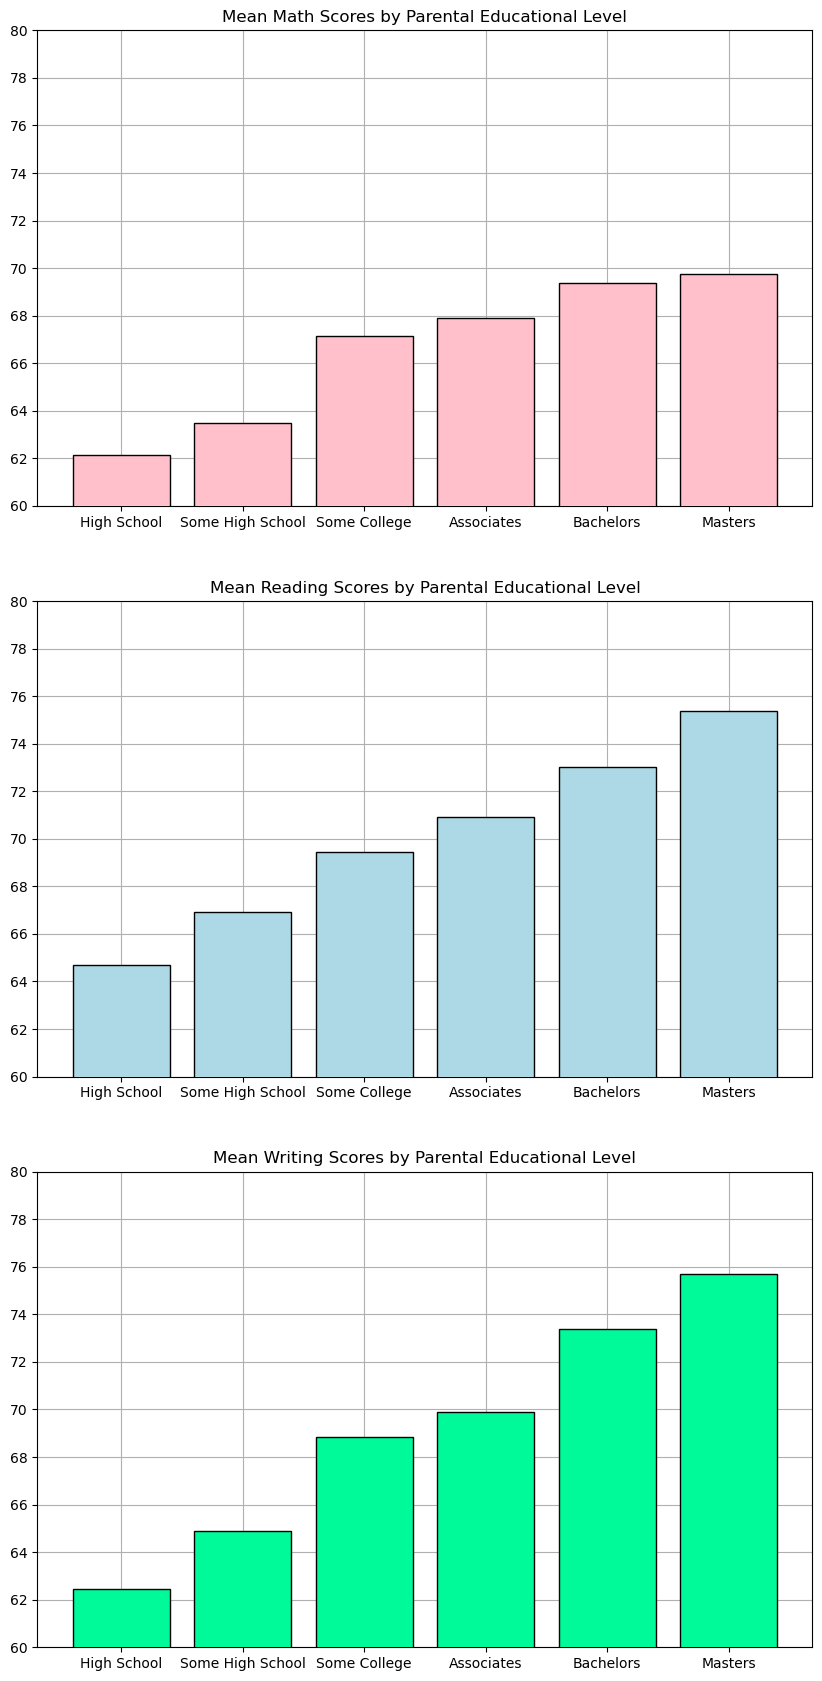

In [45]:
#creating a list that holds the mean score for each of the education levles for each of the subjects
math_heights = [np.mean(associates_math_scores),np.mean(bachelors_math_scores),np.mean(masters_math_scores),np.mean(highschool_math_scores),np.mean(somecollege_math_scores),np.mean(somehs_math_scores)]

reading_heights = [np.mean(associates_reading_scores),np.mean(bachelors_reading_scores),np.mean(masters_reading_scores),np.mean(highschool_reading_scores),np.mean(somecollege_reading_scores),np.mean(somehs_reading_scores)]

writing_heights = [np.mean(associates_writing_scores),np.mean(bachelors_writing_scores),np.mean(masters_writing_scores),np.mean(highschool_writing_scores),np.mean(somecollege_writing_scores),np.mean(somehs_writing_scores)]

math_heights.sort(); reading_heights.sort(); writing_heights.sort()

#creating a list holding the titles for each of the subplots 
titles = ['Mean Math Scores by Parental Educational Level','Mean Reading Scores by Parental Educational Level','Mean Writing Scores by Parental Educational Level']

#initializng the plot figure
fig,axs = plt.subplots(nrows=3,ncols=1,figsize=(10,21))

#plottig the bar graphs on each of subplots
axs[0].bar(range(6),math_heights,color='pink',edgecolor='black',zorder=20)

axs[1].bar(range(6),reading_heights,color='lightblue',edgecolor='black',zorder=20)

axs[2].bar(range(6),writing_heights,color='mediumspringgreen',edgecolor='black',zorder=20)

#iterating over the axes
for i in range(3):
    
    #setting the title of each of the subplots 
    axs[i].set_title(titles[i])
    
    #setting the x ticks to show the education level
    axs[i].set_xticks(ticks=range(6),labels=['High School', 'Some High School','Some College','Associates','Bachelors','Masters'])
    
    #setting the y ticks
    axs[i].set_yticks(ticks=[i for i in range(60,82,2)])
    
    #setting the y limit
    axs[i].set_ylim(60,80)
    
    #plotting the grid
    axs[i].grid()

### Results

Going back to the original question that this data analysis intended to answer, we wanted to know what characteristics/attributes of a student affect their testing success. With this information, there are opportunities to expose some of the current shortcomings of the education system by showing what types of student characteristics have a negative effect on test scores. 

Doing analysis on four separate characteristics, those being sex, ethnicity, lunch type, and parental education level, a lot of information has been brought forward from the data. 

Looking at the difference in test scores between sexes using the z and t tests, there was found to be a significant difference in mean scores for all 3 subjects between the two groups. There is no clean cut advantage to being of one sex or another, but there is evidence to say that the current education system impacted the scores of males and female differently. 

When analyzing the ethnicity groups, the p-value matrix was not entirely significant. However, when pairing the matrix results with the visualization of mean scores across the different groups using a bar graph, we found that some groups were very close in terms of means while other were very different. These findings from the bar graph matched the results from the p-values in the matrix. It was apparent that while some ethnicity groups produced typical average exam scores, other ethnicity groups struggled with one group having an average math score of only about 62 percent. We can conclude that there is strong evidence supporting that ethnicity is a factor in the academic success of students and that is not to say that one group is smarter than others. 

The next factor that was inspected was how the lunch types of students impacted their test scores. Much like the sex analysis, the mean scores across all subjects showed a significant difference in population when conducting the z and t tests. The biggest nominal difference in mean came in at almost a 12% difference! That is, the standard lunch students performed a lot better than their reduced lunch counterparts. There is evidence to suggest that the lunch type of students is a factor in determining their success on tests. 

The final factor that was investigated was the parental level of education in the students. Like the analysis of ethnicity groups, the p-value matrix was colorful and was not entirely significant. We found that similar degree levels provided an insignificant difference in mean test scores in their children, while differing levels of education such as high school to masters created a significant difference. Thus, there is evidence that the parental level of education is a factor, however it can be seen as a discrete factor meaning that if the different levels are merged into no high school, high school, or college, then the significance is fully seen. 

The motivation for this choice of analysis was growing up around schools in Chicago and in Flint that have struggled in terms of funding which as a consequence has negatively affected the students of those districts. Looking at the results of this analysis, it is seen that the negatively impactful traits of students such as reduced lunch, low parental education, and specific ethnicities are synonymous with the conditions of these types of school districts. There are limitations within this data as there is not information about the grade of the students in the set or school district/s from which the data comes from. However, there is a lot of initial evidence that all 4 of the factors investigated play a part in the success of students. 


### References 

The only outside source for this analysis comes from Kaggle. The link to the dataset is in the first section.